### Top 10 Algorithms for Binary Classification 

1. Naive Bayes
2. Logistic Regression
3. K-Nearest Neighbours
4. Support Vector Machine
5. Decision Tree 
6. Bagging  Decision Tree (Ensemble Learning I)
7. Boosted Decision Tree (Ensemble Learning II)
8. Random Forest (Ensemble Learning III)
9. Voting Classification (Ensemble Learning IV)
10. Deep Learning with a neuronal network

https://github.com/alexortner/teaching/blob/master/binary_classification/Top_10_Binary_Classification_BreastCancer.ipynb

***Comparaciones de bootstrap***
* 1	Aproximación normal	95,6%
* 2.1	Bootstrap, IC de 1 muestra	98,5%
* 2.2	Bootstrap, percentil	98,0%
* 2.3	Arranque, .632	83,2%
* 3	Conjunto de prueba de arranque	94,5%

Tanto la aproximación normal (método 1) como el arranque de los conjuntos de prueba (método 3) son opciones prácticas y precisas. Cuando se trata explícitamente de modelos de aprendizaje profundo, considerar diferentes semillas aleatorias (método 4) es otra técnica que vale la pena considerar. Tenga en cuenta que los métodos 1 y 2 son convenientes, ya que no requieren entrenar varios modelos, a diferencia del método 4. Sin embargo, el método 4 puede ser atractivo para las comparaciones de algoritmos, ya que también nos dice qué tan dependiente es un algoritmo de la semilla aleatoria. 

In [1]:
import sys
assert sys.version_info >= (3, 5)
import os
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore') # Para evitar los molestos avisos.
%matplotlib inline

In [87]:
# Estandarizador (transforma las variables en z-scores)
import scipy.stats as st
from sklearn.model_selection import RandomizedSearchCV, train_test_split, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, classification_report, mean_squared_error, confusion_matrix, accuracy_score, precision_score, recall_score, mean_squared_error, ConfusionMatrixDisplay # Accuracy metrics 
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures, StandardScaler
from scikitplot.metrics import plot_roc


In [5]:
import utils as ut
import pickle
# Indicamos que los tipos de datos float se muestren con 2 decimales
pd.options.display.float_format = '{:.2f}'.format

In [6]:
def balanced_accuracy(cm): # funcion para calcular la "balanced accuracy"
  sensibilidad = cm[1,1]/(cm[1,1]+cm[0,1])
  especificidad = cm[0,0]/(cm[1,0]+cm[0,0])
  return [sensibilidad, especificidad, (sensibilidad + especificidad)/2]

In [155]:
# K-Fold Cross-Validation
from sklearn.model_selection import cross_validate
def cross_validation(model, _X, _y, _cv=5):
      '''Function to perform 5 Folds Cross-Validation
       Parameters
       ----------
      model: Python Class, default=None
              This is the machine learning algorithm to be used for training.
      _X: array
           This is the matrix of features.
      _y: array
           This is the target variable.
      _cv: int, default=5
          Determines the number of folds for cross-validation.
       Returns
       -------
       The function returns a dictionary containing the metrics 'accuracy', 'precision',
       'recall', 'f1' for both training set and validation set.
      '''
      _scoring = ['accuracy', 'precision', 'recall', 'f1']
      results = cross_validate(estimator=model,
                               X=_X,
                               y=_y,
                               cv=_cv,
                               scoring=_scoring,
                               return_train_score=True)
      
      return {"Training Accuracy scores": results['train_accuracy'],
              "Mean Training Accuracy": results['train_accuracy'].mean()*100,
              "Training Precision scores": results['train_precision'],
              "Mean Training Precision": results['train_precision'].mean(),
              "Training Recall scores": results['train_recall'],
              "Mean Training Recall": results['train_recall'].mean(),
              "Training F1 scores": results['train_f1'],
              "Mean Training F1 Score": results['train_f1'].mean(),
              "Validation Accuracy scores": results['test_accuracy'],
              "Mean Validation Accuracy": results['test_accuracy'].mean()*100,
              "Validation Precision scores": results['test_precision'],
              "Mean Validation Precision": results['test_precision'].mean(),
              "Validation Recall scores": results['test_recall'],
              "Mean Validation Recall": results['test_recall'].mean(),
              "Validation F1 scores": results['test_f1'],
              "Mean Validation F1 Score": results['test_f1'].mean()
              }

In [150]:
# Grouped Bar Chart for both training and validation data
def plot_result(x_label, y_label, plot_title, train_data, val_data):
        '''Function to plot a grouped bar chart showing the training and validation
          results of the ML model in each fold after applying K-fold cross-validation.
         Parameters
         ----------
         x_label: str, 
            Name of the algorithm used for training e.g 'Decision Tree'
          
         y_label: str, 
            Name of metric being visualized e.g 'Accuracy'
         plot_title: str, 
            This is the title of the plot e.g 'Accuracy Plot'
         
         train_result: list, array
            This is the list containing either training precision, accuracy, or f1 score.
        
         val_result: list, array
            This is the list containing either validation precision, accuracy, or f1 score.
         Returns
         -------
         The function returns a Grouped Barchart showing the training and validation result
         in each fold.
        '''
        
        # Set size of plot
        plt.figure(figsize=(12,6))
        labels = ["1st Fold", "2nd Fold", "3rd Fold", "4th Fold", "5th Fold"]
        X_axis = np.arange(len(labels))
        ax = plt.gca()
        plt.ylim(0.40000, 1)
        plt.bar(X_axis-0.2, train_data, 0.4, color='blue', label='Training')
        plt.bar(X_axis+0.2, val_data, 0.4, color='red', label='Validation')
        plt.title(plot_title, fontsize=30)
        plt.xticks(X_axis, labels)
        plt.xlabel(x_label, fontsize=14)
        plt.ylabel(y_label, fontsize=14)
        plt.legend()
        plt.grid(True)
        plt.show()

In [7]:
DATA_PATH = "../data/union/End"
def load_data_prep(data_path=DATA_PATH):
    csv_path = os.path.join(data_path, "dataset_final.csv")
    return pd.read_csv(csv_path)

In [8]:
df = load_data_prep()

In [9]:
df1 = df[[ 'ccbd_diameter', 'sl2l_mean_length',
 'sl2l_diameter', 'ccbd_mean_length',
 'sl2l_volume', 'tral_volume','label']]
df1.shape

(96, 7)

In [273]:
# Partición en train y test
y = df1.loc[:, df1.columns == 'label']
X = df1.loc[:, df1.columns != 'label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=99)

In [274]:
X_= X_train.reset_index()
y_= y_train.reset_index()
X_=X_.drop('index', axis=1)
y_=y_.drop('index', axis=1)

In [13]:
std_scale = StandardScaler() # Creamos el estandarizador para usarlo posteriormente
minmx_scale = MinMaxScaler()

In [278]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression # sci-kit learn
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import StratifiedKFold


In [279]:
pipelines = {
    'mnb':make_pipeline(MinMaxScaler(), MultinomialNB()),
    'lr':make_pipeline(StandardScaler(), LogisticRegression(fit_intercept=True, penalty='l2', tol=1e-5, C=0.8, class_weight='balanced', solver='newton-cg', max_iter=5000, warm_start=True)),
    'knn':make_pipeline(StandardScaler(), KNeighborsClassifier(algorithm = 'brute', n_jobs=-1)),
    'svm':make_pipeline(StandardScaler(), LinearSVC(C=0.0001)),
    'clf':make_pipeline(StandardScaler(), DecisionTreeClassifier(min_samples_split=10,max_depth=3)),
    'bg':make_pipeline(StandardScaler(), BaggingClassifier(DecisionTreeClassifier(min_samples_split=10,max_depth=3),max_samples=0.5,max_features=1.0,n_estimators=10)),
    'adb':make_pipeline(StandardScaler(), AdaBoostClassifier(DecisionTreeClassifier(max_depth=2),n_estimators=100,learning_rate=0.5)),
    'rf':make_pipeline(StandardScaler(), RandomForestClassifier(n_estimators=300,max_depth=3)),
    'evc':make_pipeline(MinMaxScaler(), VotingClassifier(estimators=[('mnb',mnb),('lr',lr),('rf',rf),('svm',svm)]))}


In [280]:
skf = StratifiedKFold(n_splits=5, shuffle=True) # 5 folds es un número típico si tenemos suficientes datos. Pedimos shuffle=True para que sea al azar la separación en subgrupos
skf.get_n_splits(X_, y_) # arma los folds a partir de los datos

# acc_values = [] # aca es donde van a ir a parar los accuracys de cada fold
# pr_sc_values = [] # aca es donde van a ir a parar los accuracys de cada fold
# rc_sc_values = [] # aca es donde van a ir a parar los accuracys de cada fold
# scores = np.array([])     # aca es donde van a ir a parar los scores computados para todos los casos
# indices = np.array([])    # aca es donde van a ir a parar los indices correspondientes a las entradas de scores
fit_models = {}

for algo, pipeline in pipelines.items():
      acc_values = []
      pr_sc_values = [] 
      rc_sc_values = []
      for train_index, test_index in skf.split(X_, y_): # va generando los indices que corresponden a train y test en cada fold
            X_train_, X_test_ = X_.iloc[train_index], X_.iloc[test_index] # arma que es dato de entrenamiento y qué es dato de evaluación
            y_train_, y_test_ = y_.iloc[train_index], y_.iloc[test_index]     # idem con los targets
            
            #scaler = MinMaxScaler() # primero creo un objeto MinMaxScaler. Por defecto, esto normaliza los datos al intervalo [0,1]
            #scaler.fit(X_train_) # encuentro los parametros para el escaleo
            #X_train_ = scaler.transform(X_train_) # aplico la transformacion

            #scaler = MinMaxScaler() # primero creo un objeto MinMaxScaler. Por defecto, esto normaliza los datos al intervalo [0,1]
            #scaler.fit(X_test_) # encuentro los parametros para el escaleo
            #X_test_ = scaler.transform(X_test_) # aplico la transformacion
            
            model = pipeline.fit(X_train_, np.ravel(y_train_))
            probas_test = model.predict(X_test_)  # probabilidades con datos de evaluación
            
            acc_test = accuracy_score(y_test_, probas_test)
            pr_sc = precision_score(y_test_.values, probas_test, average="weighted", pos_label=1)
            rc_sc = recall_score(y_test_.values, probas_test, average="weighted", pos_label=1)
            
            acc_values.append(acc_test)
            pr_sc_values.append(pr_sc)
            rc_sc_values.append(rc_sc)
            
            print(algo,'ac-sc: {}'.format(round(accuracy_score(y_test_, probas_test),3)),
                  'pr-sc: {}'.format(round(precision_score(y_test_.values, probas_test, average="weighted", pos_label="arriba"),3)),
                  'rc-sc: {}'.format(round(recall_score(y_test_.values, probas_test, average="weighted", pos_label="arriba"),3)))
      fit_models[algo] = model
            
      print('----------------------------------------------------')
      print('--------------PROMEDIOS--DE--',algo,'-------------------------')
      print('Accuracy {}'.format(round(np.mean(acc_values),3)), 
      'precision_score {}'.format(round(np.mean(pr_sc_values),3)),
      'recall_score {}'.format(round(np.mean(rc_sc_values),3)))
      print('----------------------------------------------------')
      print('----------------------------------------------------')
      # fpr_test, tpr_test, thresholds_test = roc_curve(y_test, probas_test[:,1]) # para plotear curva ROC con datos de entrenamiento
      # auc_test = roc_auc_score(y_test, probas_test[:,1]) #  AUC con datos de evaluación

      # auc_values.append(auc_test)
      # scores = np.concatenate((scores,probas_test[:,1]),axis=0)
      # indices = np.concatenate((indices,test_index),axis=0)
      fit_models[algo] = model

mnb ac-sc: 0.938 pr-sc: 0.944 rc-sc: 0.938
mnb ac-sc: 0.6 pr-sc: 0.615 rc-sc: 0.6
mnb ac-sc: 0.733 pr-sc: 0.83 rc-sc: 0.733
mnb ac-sc: 0.667 pr-sc: 0.806 rc-sc: 0.667
mnb ac-sc: 0.667 pr-sc: 0.673 rc-sc: 0.667
----------------------------------------------------
--------------PROMEDIOS--DE-- mnb -------------------------
Accuracy 0.721 precision_score 0.774 recall_score 0.721
----------------------------------------------------
----------------------------------------------------
lr ac-sc: 0.562 pr-sc: 0.767 rc-sc: 0.562
lr ac-sc: 0.933 pr-sc: 0.942 rc-sc: 0.933
lr ac-sc: 0.8 pr-sc: 0.804 rc-sc: 0.8
lr ac-sc: 0.6 pr-sc: 0.615 rc-sc: 0.6
lr ac-sc: 0.6 pr-sc: 0.655 rc-sc: 0.6
----------------------------------------------------
--------------PROMEDIOS--DE-- lr -------------------------
Accuracy 0.699 precision_score 0.756 recall_score 0.699
----------------------------------------------------
----------------------------------------------------
knn ac-sc: 0.75 pr-sc: 0.75 rc-sc: 0.75
knn

In [14]:
# Ajustamos el estandarizador
std_scale.fit(X_test)
std_scale.fit(X_train)
minmx_scale.fit(X_test)
minmx_scale.fit(X_train)

# Aplicamos el estandarizador y obtenemos la matriz de features escaleados
X_test_scaled = std_scale.transform(X_test)
X_scaled = std_scale.transform(X_train)
X_test_norm =  minmx_scale.transform(X_test)
X_norm = minmx_scale.transform(X_train)

### 1. Naive Bayes

In [15]:
from sklearn.naive_bayes import MultinomialNB

In [281]:
y_predicted = fit_models['mnb'].predict_proba(X_test)

In [16]:
# mnb = MultinomialNB().fit(X_norm, y_train)

In [282]:
print("train shape: " + str(X_train.shape))
print("score on test: " + str(fit_models['mnb'].score(X_test, y_test)))
print("score on train: "+ str(fit_models['mnb'].score(X_train, y_train)))

train shape: (76, 6)
score on test: 0.85
score on train: 0.7236842105263158


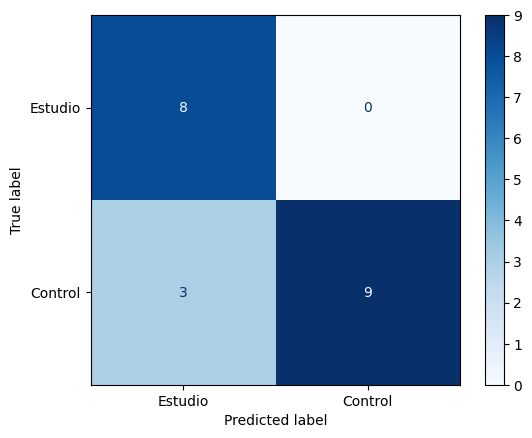

In [283]:
class_names = ['Estudio', 'Control']
ConfusionMatrixDisplay.from_estimator(fit_models['mnb'], X_test, y_test, display_labels=class_names, cmap=plt.cm.Blues)
plt.show()

In [284]:
print(classification_report(y_true=y_test,y_pred=fit_models['mnb'].predict(X_test)))

              precision    recall  f1-score   support

           0       0.73      1.00      0.84         8
           1       1.00      0.75      0.86        12

    accuracy                           0.85        20
   macro avg       0.86      0.88      0.85        20
weighted avg       0.89      0.85      0.85        20



<Axes: title={'center': 'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

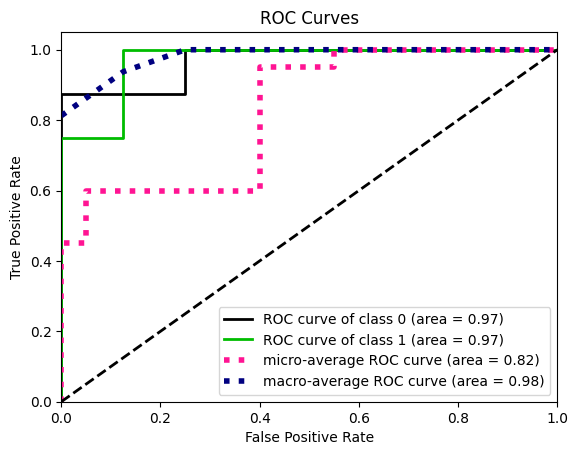

In [285]:
y_predicted = fit_models['mnb'].predict_proba(X_test_norm)
plot_roc(y_test, y_predicted)

In [324]:
y_= y_train.label.values
mnb_ = MultinomialNB()
mnb_result = cross_validation(mnb_, X_norm.tolist(), y_.tolist(), 5)
mnb_result

{'Training Accuracy scores': array([0.75      , 0.75409836, 0.73770492, 0.68852459, 0.70491803]),
 'Mean Training Accuracy': 72.70491803278689,
 'Training Precision scores': array([0.74193548, 0.7       , 0.69230769, 0.76190476, 0.83333333]),
 'Mean Training Precision': 0.745896254283351,
 'Training Recall scores': array([0.76666667, 0.90322581, 0.87096774, 0.53333333, 0.5       ]),
 'Mean Training Recall': 0.7148387096774194,
 'Training F1 scores': array([0.75409836, 0.78873239, 0.77142857, 0.62745098, 0.625     ]),
 'Mean Training F1 Score': 0.7133420613685326,
 'Validation Accuracy scores': array([0.6875    , 0.53333333, 0.53333333, 0.73333333, 0.6       ]),
 'Mean Validation Accuracy': 61.74999999999999,
 'Validation Precision scores': array([0.71428571, 0.5       , 0.5       , 1.        , 0.66666667]),
 'Mean Validation Precision': 0.6761904761904762,
 'Validation Recall scores': array([0.625     , 0.71428571, 0.85714286, 0.5       , 0.5       ]),
 'Mean Validation Recall': 0.6392

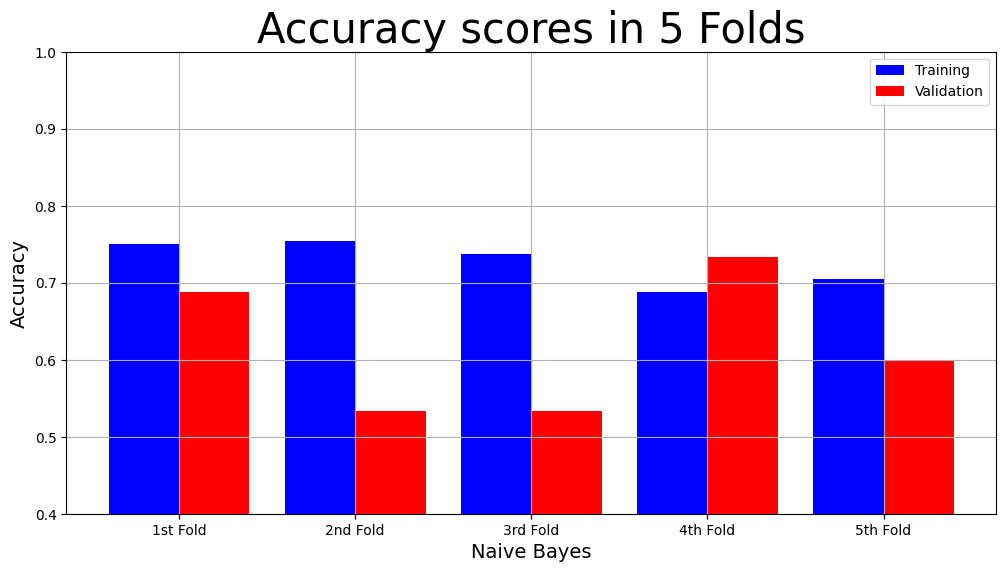

In [325]:
model_name = "Naive Bayes"
plot_result(model_name,
            "Accuracy",
            "Accuracy scores in 5 Folds",
            mnb_result["Training Accuracy scores"],
            mnb_result["Validation Accuracy scores"])

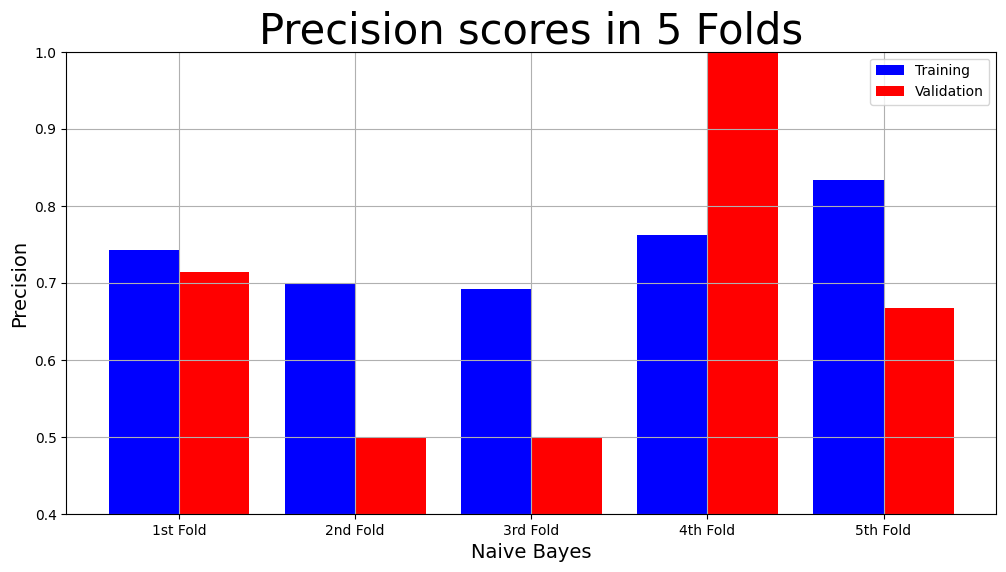

In [227]:
# Plot Precision Result
plot_result(model_name,
            "Precision",
            "Precision scores in 5 Folds",
            mnb_result["Training Precision scores"],
            mnb_result["Validation Precision scores"])

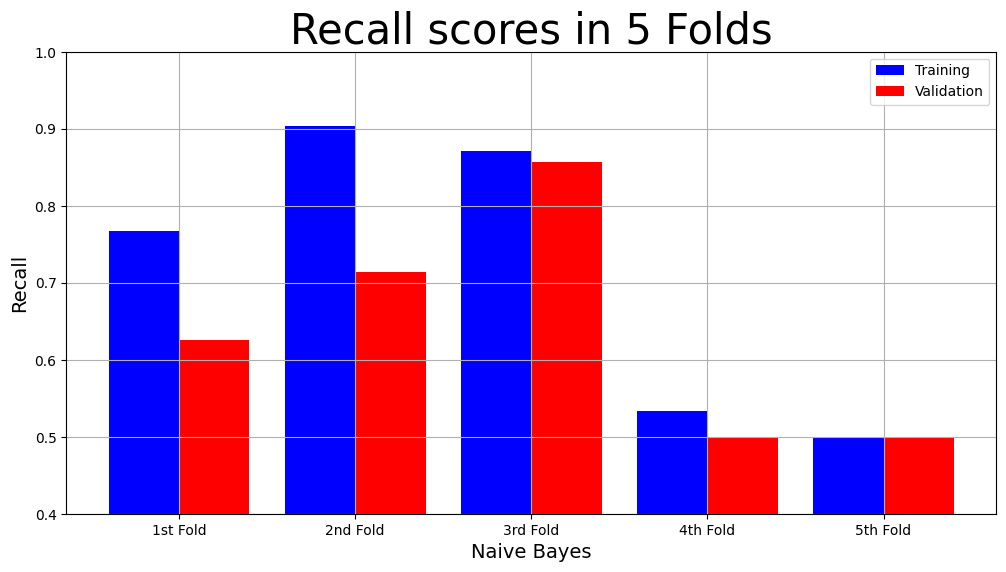

In [228]:
# Plot Recall Result
plot_result(model_name,
            "Recall",
            "Recall scores in 5 Folds",
            mnb_result["Training Recall scores"],
            mnb_result["Validation Recall scores"])

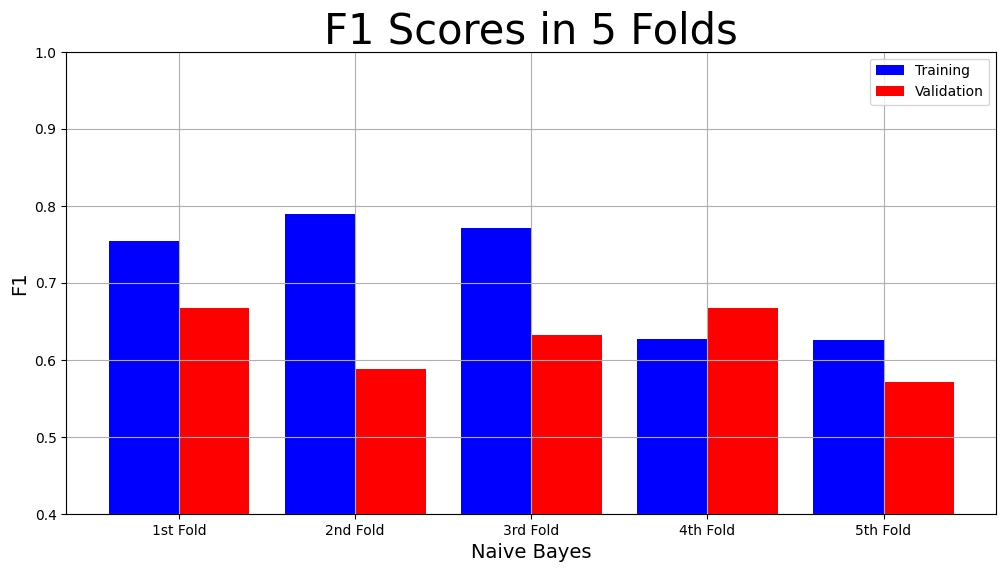

In [229]:
# Plot F1-Score Result
plot_result(model_name,
            "F1",
            "F1 Scores in 5 Folds",
            mnb_result["Training F1 scores"],
            mnb_result["Validation F1 scores"])

### 2. Logistic Regression

In [19]:
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression # sci-kit learn

In [286]:
# lr = LogisticRegression(fit_intercept=True, penalty='l2', tol=1e-5, C=0.8, class_weight='balanced', solver='newton-cg', max_iter=5000, warm_start=True)
# lr.fit(X_scaled, y_train)

print("train shape: " + str(X_train.shape))
print("score on test: " + str(fit_models['lr'].score(X_test, y_test)))
print("score on train: "+ str(fit_models['lr'].score(X_train, y_train)))

train shape: (76, 6)
score on test: 0.95
score on train: 0.7105263157894737


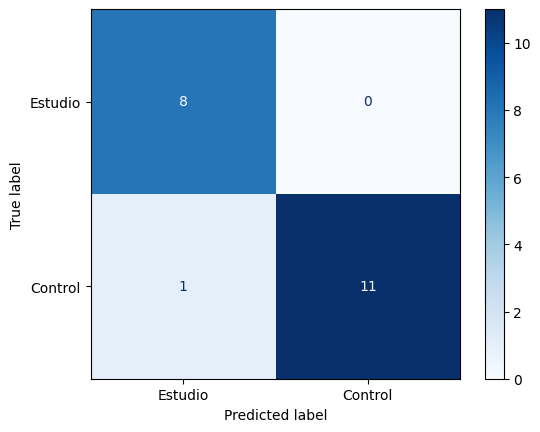

In [287]:
class_names = ['Estudio', 'Control']
ConfusionMatrixDisplay.from_estimator(fit_models['lr'], X_test, y_test, display_labels=class_names, cmap=plt.cm.Blues)
plt.show()

In [288]:
print(classification_report(y_true=y_test,y_pred=fit_models['lr'].predict(X_test)))

              precision    recall  f1-score   support

           0       0.89      1.00      0.94         8
           1       1.00      0.92      0.96        12

    accuracy                           0.95        20
   macro avg       0.94      0.96      0.95        20
weighted avg       0.96      0.95      0.95        20



<Axes: title={'center': 'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

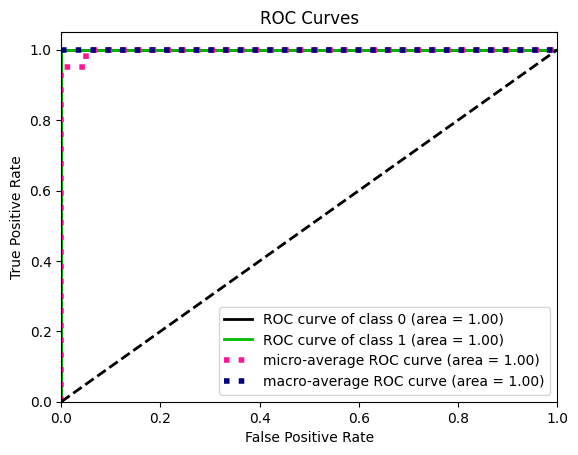

In [289]:
y_predicted = fit_models['lr'].predict_proba(X_test)
plot_roc(y_test, y_predicted)

In [231]:
lr = LogisticRegression(fit_intercept=True, penalty='l2', tol=1e-5, C=0.8, class_weight='balanced', solver='newton-cg', max_iter=5000, warm_start=True)
lr_result = cross_validation(lr, X_scaled, y_train, 5)
lr_result

{'Training Accuracy scores': array([0.71666667, 0.78688525, 0.73770492, 0.75409836, 0.78688525]),
 'Mean Training Accuracy': 75.6448087431694,
 'Training Precision scores': array([0.70967742, 0.78125   , 0.74193548, 0.77777778, 0.81481481]),
 'Mean Training Precision': 0.7650910991636798,
 'Training Recall scores': array([0.73333333, 0.80645161, 0.74193548, 0.7       , 0.73333333]),
 'Mean Training Recall': 0.743010752688172,
 'Training F1 scores': array([0.72131148, 0.79365079, 0.74193548, 0.73684211, 0.77192982]),
 'Mean Training F1 Score': 0.7531339365512316,
 'Validation Accuracy scores': array([0.8125    , 0.4       , 0.86666667, 0.8       , 0.53333333]),
 'Mean Validation Accuracy': 68.24999999999999,
 'Validation Precision scores': array([0.85714286, 0.375     , 0.85714286, 1.        , 0.6       ]),
 'Mean Validation Precision': 0.7378571428571429,
 'Validation Recall scores': array([0.75      , 0.42857143, 0.85714286, 0.625     , 0.375     ]),
 'Mean Validation Recall': 0.60714

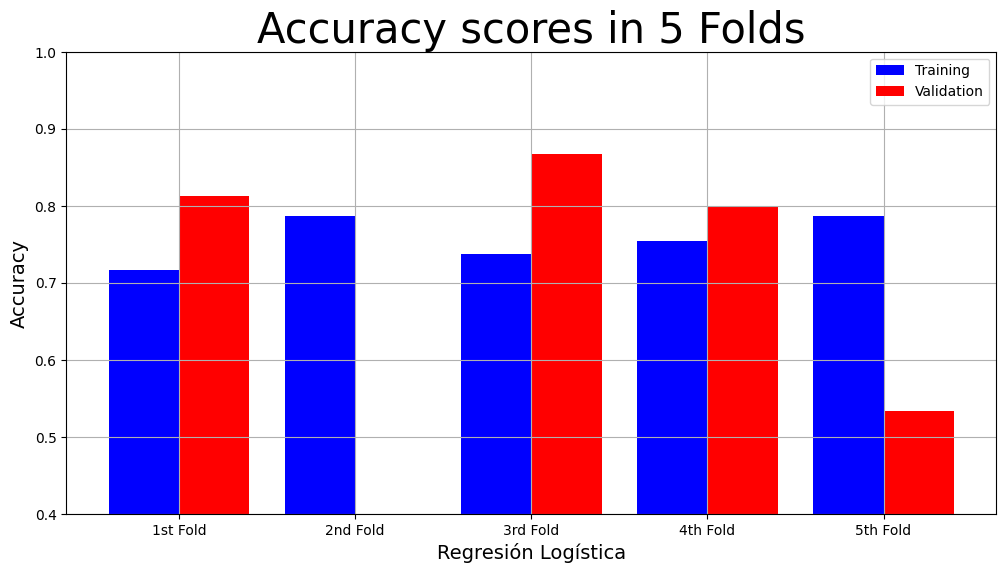

In [232]:
model_name = "Regresión Logística"
plot_result(model_name,
            "Accuracy",
            "Accuracy scores in 5 Folds",
            lr_result["Training Accuracy scores"],
            lr_result["Validation Accuracy scores"])

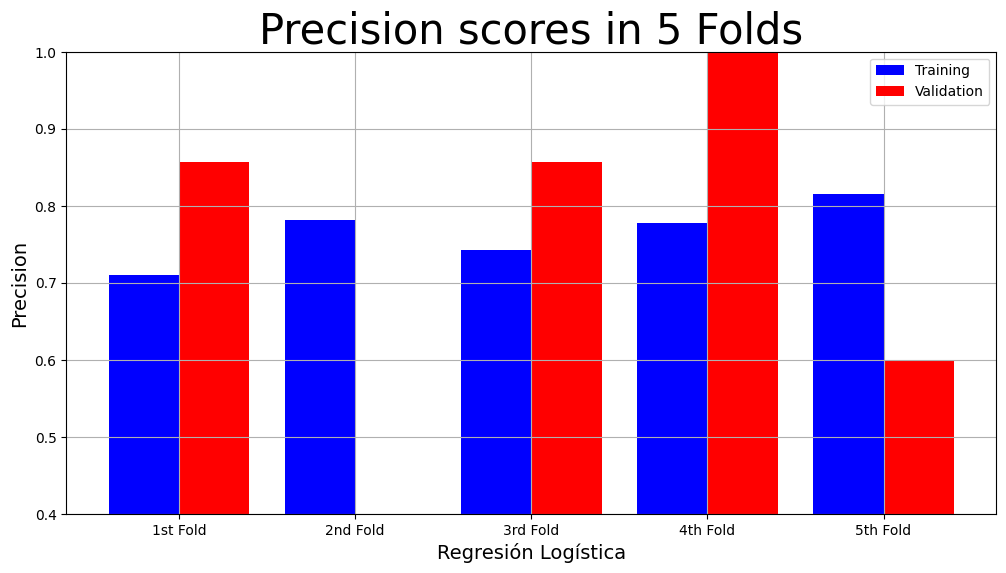

In [233]:
# Plot Precision Result
plot_result(model_name,
            "Precision",
            "Precision scores in 5 Folds",
            lr_result["Training Precision scores"],
            lr_result["Validation Precision scores"])

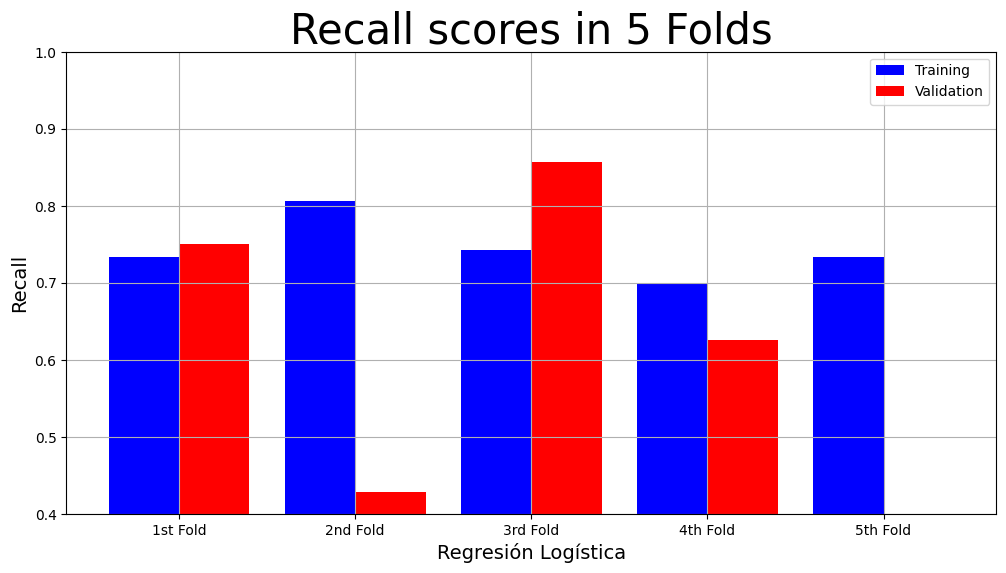

In [234]:
# Plot Recall Result
plot_result(model_name,
            "Recall",
            "Recall scores in 5 Folds",
            lr_result["Training Recall scores"],
            lr_result["Validation Recall scores"])

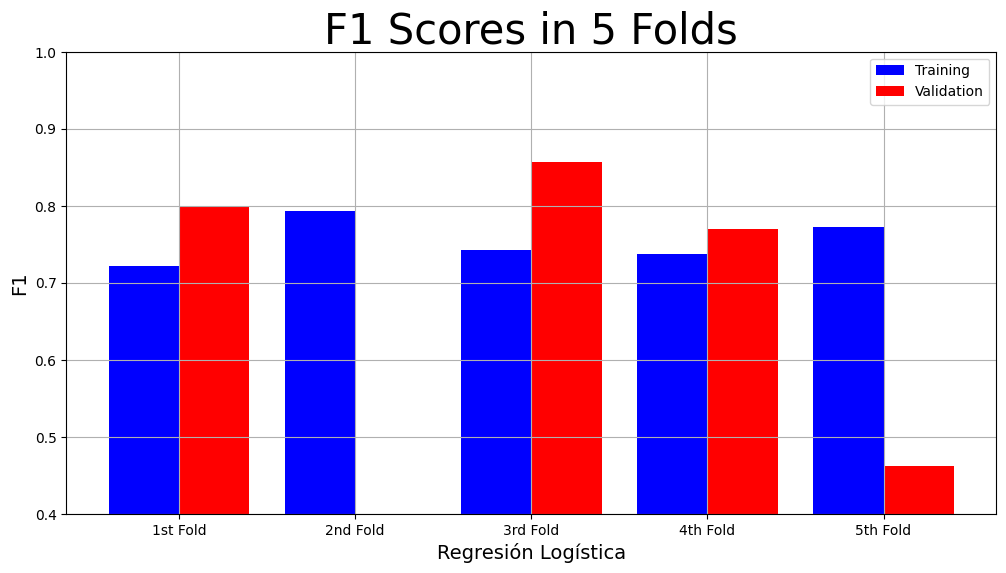

In [235]:
# Plot F1-Score Result
plot_result(model_name,
            "F1",
            "F1 Scores in 5 Folds",
            lr_result["Training F1 scores"],
            lr_result["Validation F1 scores"])

### 3. K-Nearest Neighbours

In [290]:
%%time

from sklearn.neighbors import KNeighborsClassifier

#knn = KNeighborsClassifier(n_neighbors=5,algorithm = 'ball_tree')
## knn = KNeighborsClassifier(algorithm = 'brute', n_jobs=-1)

# knn.fit(X_scaled, y_train)

print("train shape: " + str(X_train.shape))
print("score on test: " + str(fit_models['knn'].score(X_test, y_test)))
print("score on train: "+ str(fit_models['knn'].score(X_train, y_train)))

train shape: (76, 6)
score on test: 0.8
score on train: 0.75
CPU times: total: 0 ns
Wall time: 27.7 ms


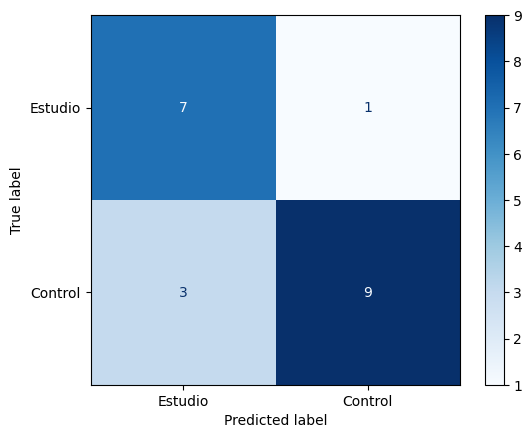

In [291]:
class_names = ['Estudio', 'Control']
ConfusionMatrixDisplay.from_estimator(fit_models['knn'], X_test, y_test, display_labels=class_names, cmap=plt.cm.Blues)
plt.show()

In [292]:
print(classification_report(y_true=y_test,y_pred=fit_models['knn'].predict(X_test)))

              precision    recall  f1-score   support

           0       0.70      0.88      0.78         8
           1       0.90      0.75      0.82        12

    accuracy                           0.80        20
   macro avg       0.80      0.81      0.80        20
weighted avg       0.82      0.80      0.80        20



<Axes: title={'center': 'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

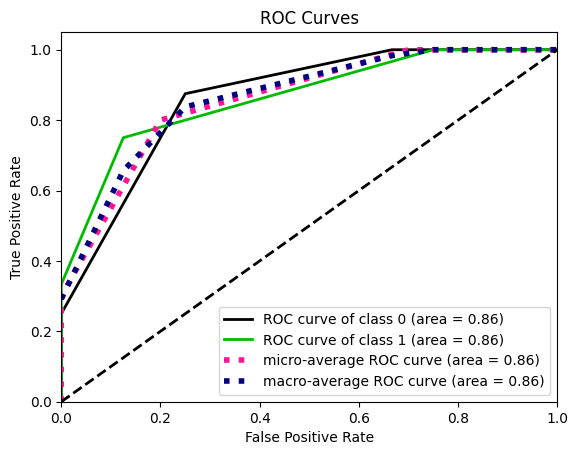

In [293]:
y_predicted = fit_models['knn'].predict_proba(X_test)
plot_roc(y_test, y_predicted)

In [236]:
knn = KNeighborsClassifier(algorithm = 'brute', n_jobs=-1)
knn_result = cross_validation(knn, X_scaled, y_train, 5)
knn_result

{'Training Accuracy scores': array([0.78333333, 0.78688525, 0.78688525, 0.80327869, 0.85245902]),
 'Mean Training Accuracy': 80.25683060109289,
 'Training Precision scores': array([0.79310345, 0.78125   , 0.73684211, 0.78125   , 0.81818182]),
 'Mean Training Precision': 0.7821254743441677,
 'Training Recall scores': array([0.76666667, 0.80645161, 0.90322581, 0.83333333, 0.9       ]),
 'Mean Training Recall': 0.8419354838709678,
 'Training F1 scores': array([0.77966102, 0.79365079, 0.8115942 , 0.80645161, 0.85714286]),
 'Mean Training F1 Score': 0.8097000967089161,
 'Validation Accuracy scores': array([0.625     , 0.46666667, 0.53333333, 0.66666667, 0.66666667]),
 'Mean Validation Accuracy': 59.16666666666666,
 'Validation Precision scores': array([0.58333333, 0.33333333, 0.5       , 0.71428571, 0.71428571]),
 'Mean Validation Precision': 0.569047619047619,
 'Validation Recall scores': array([0.875     , 0.14285714, 0.57142857, 0.625     , 0.625     ]),
 'Mean Validation Recall': 0.5678

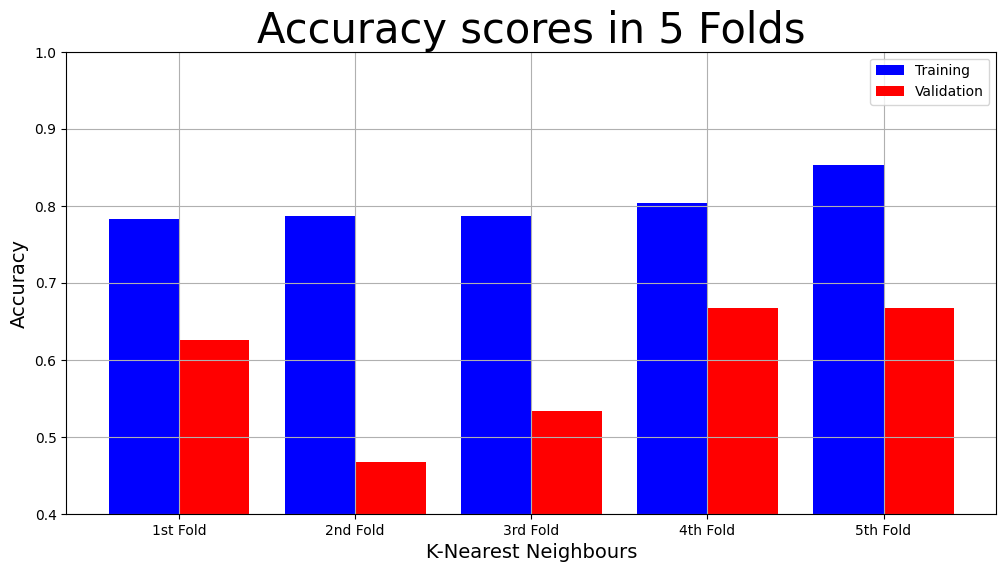

In [237]:
model_name = "K-Nearest Neighbours"
plot_result(model_name,
            "Accuracy",
            "Accuracy scores in 5 Folds",
            knn_result["Training Accuracy scores"],
            knn_result["Validation Accuracy scores"])

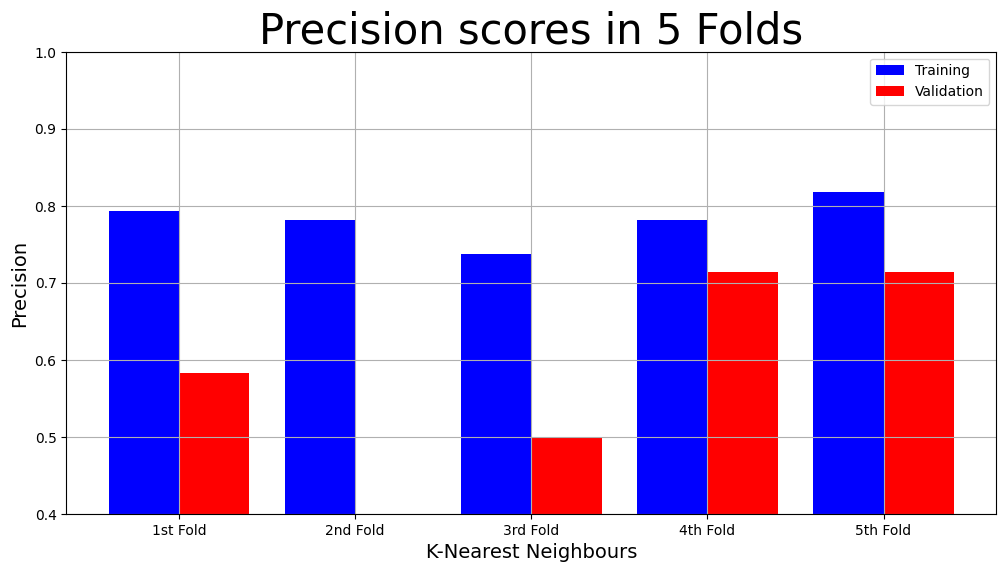

In [238]:
# Plot Precision Result
plot_result(model_name,
            "Precision",
            "Precision scores in 5 Folds",
            knn_result["Training Precision scores"],
            knn_result["Validation Precision scores"])

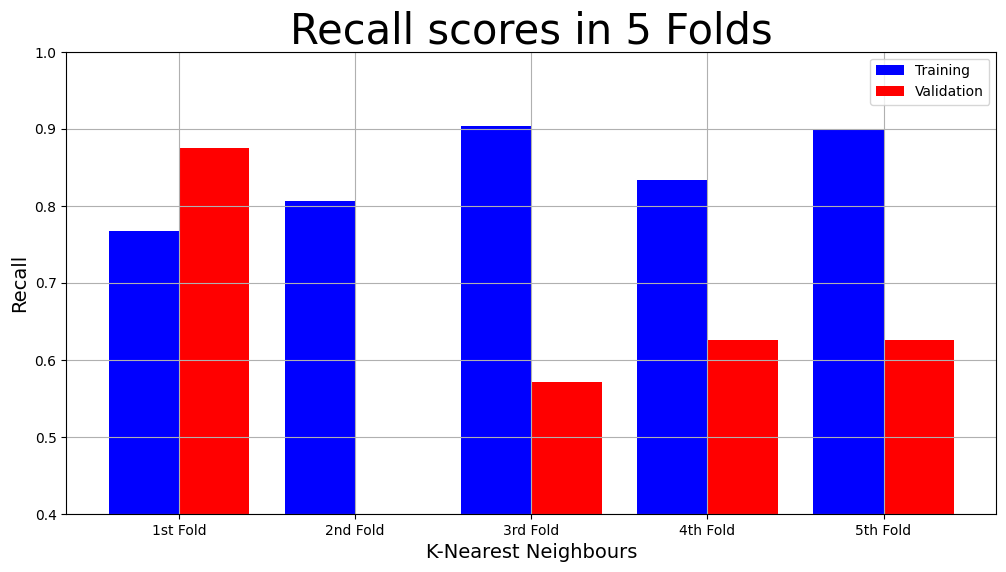

In [239]:
# Plot Recall Result
plot_result(model_name,
            "Recall",
            "Recall scores in 5 Folds",
            knn_result["Training Recall scores"],
            knn_result["Validation Recall scores"])

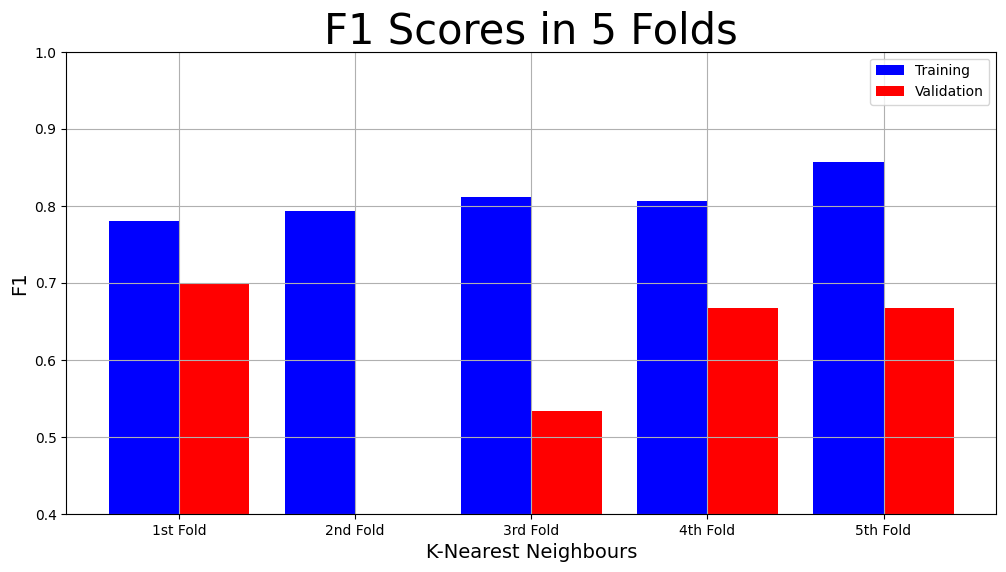

In [240]:
# Plot F1-Score Result
plot_result(model_name,
            "F1",
            "F1 Scores in 5 Folds",
            knn_result["Training F1 scores"],
            knn_result["Validation F1 scores"])

### 4. Support Vector Machine

In [294]:
%%time

from sklearn.svm import LinearSVC

#svm=LinearSVC(C=0.0001)
#svm.fit(X_scaled, y_train)

print("train shape: " + str(X_train.shape))
print("score on test: " + str(fit_models['svm'].score(X_test, y_test)))
print("score on train: "+ str(fit_models['svm'].score(X_train, y_train)))

train shape: (76, 6)
score on test: 0.95
score on train: 0.7236842105263158
CPU times: total: 0 ns
Wall time: 9.99 ms


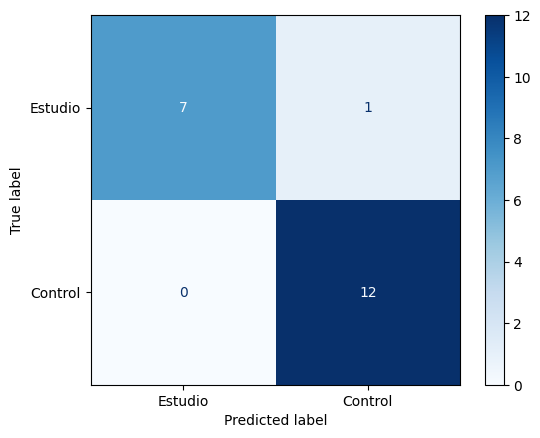

In [297]:
class_names = ['Estudio', 'Control']
ConfusionMatrixDisplay.from_estimator(fit_models['svm'], X_test, y_test, display_labels=class_names, cmap=plt.cm.Blues)
plt.show()

In [299]:
print(classification_report(y_true=y_test,y_pred=fit_models['svm'].predict(X_test)))

              precision    recall  f1-score   support

           0       1.00      0.88      0.93         8
           1       0.92      1.00      0.96        12

    accuracy                           0.95        20
   macro avg       0.96      0.94      0.95        20
weighted avg       0.95      0.95      0.95        20



In [ ]:
#y_predicted = svm._predict_proba_lr(X_test_scaled)
#y_predicted = fit_models['svm']._predict_proba_lr(X_test)
#plot_roc(y_test, y_predicted)

In [241]:
svm=LinearSVC(C=0.0001)
svm_result = cross_validation(svm, X_scaled, y_train, 5)
svm_result

{'Training Accuracy scores': array([0.71666667, 0.73770492, 0.70491803, 0.68852459, 0.78688525]),
 'Mean Training Accuracy': 72.69398907103825,
 'Training Precision scores': array([0.68571429, 0.72727273, 0.70967742, 0.68965517, 0.84      ]),
 'Mean Training Precision': 0.7304639209511289,
 'Training Recall scores': array([0.8       , 0.77419355, 0.70967742, 0.66666667, 0.7       ]),
 'Mean Training Recall': 0.7301075268817204,
 'Training F1 scores': array([0.73846154, 0.75      , 0.70967742, 0.6779661 , 0.76363636]),
 'Mean Training F1 Score': 0.7279482846295313,
 'Validation Accuracy scores': array([0.8125    , 0.4       , 0.66666667, 0.8       , 0.73333333]),
 'Mean Validation Accuracy': 68.24999999999999,
 'Validation Precision scores': array([0.85714286, 0.4       , 0.66666667, 1.        , 0.75      ]),
 'Mean Validation Precision': 0.7347619047619047,
 'Validation Recall scores': array([0.75      , 0.57142857, 0.57142857, 0.625     , 0.75      ]),
 'Mean Validation Recall': 0.653

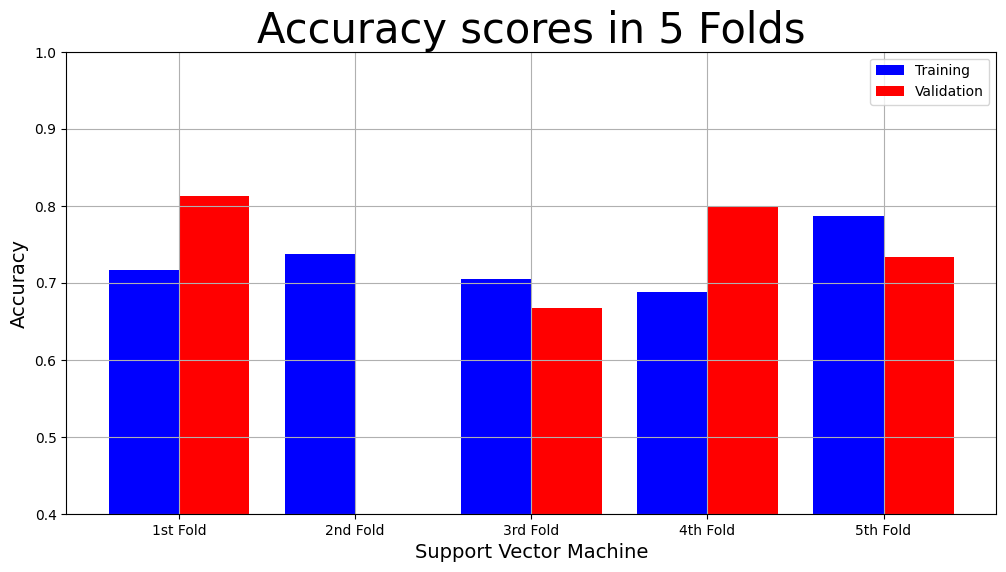

In [242]:
model_name = "Support Vector Machine"
plot_result(model_name,
            "Accuracy",
            "Accuracy scores in 5 Folds",
            svm_result["Training Accuracy scores"],
            svm_result["Validation Accuracy scores"])

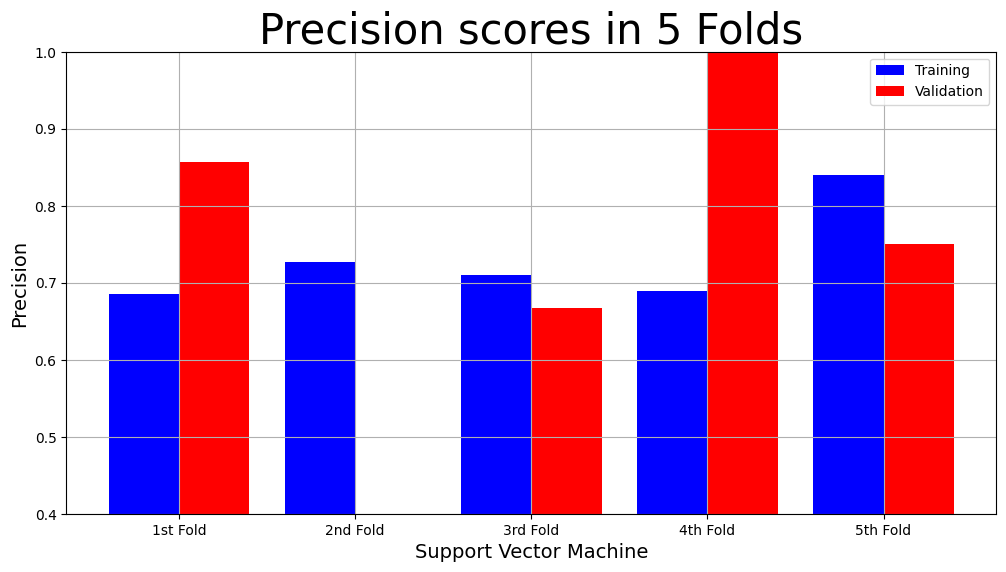

In [243]:
# Plot Precision Result
plot_result(model_name,
            "Precision",
            "Precision scores in 5 Folds",
            svm_result["Training Precision scores"],
            svm_result["Validation Precision scores"])

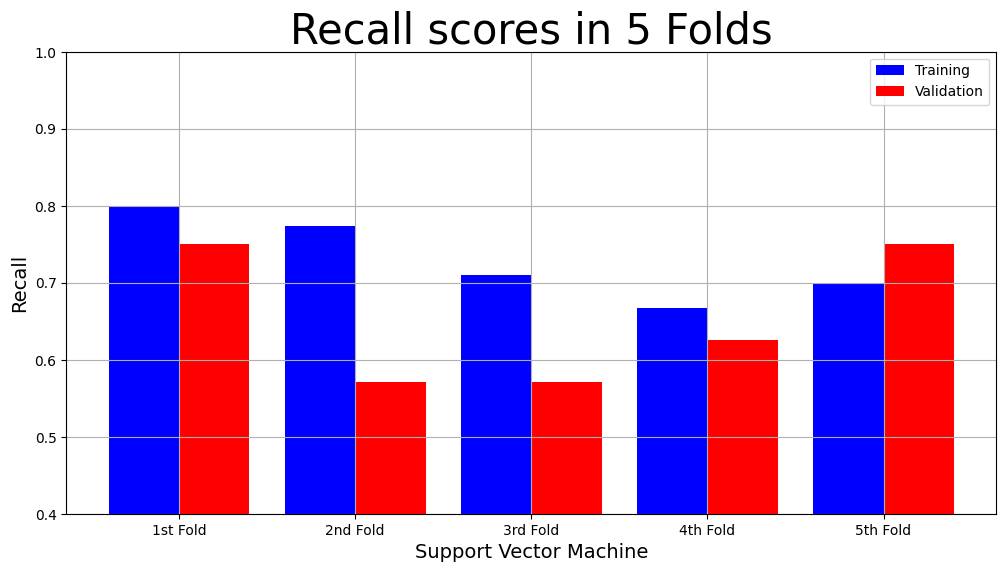

In [244]:
# Plot Recall Result
plot_result(model_name,
            "Recall",
            "Recall scores in 5 Folds",
            svm_result["Training Recall scores"],
            svm_result["Validation Recall scores"])

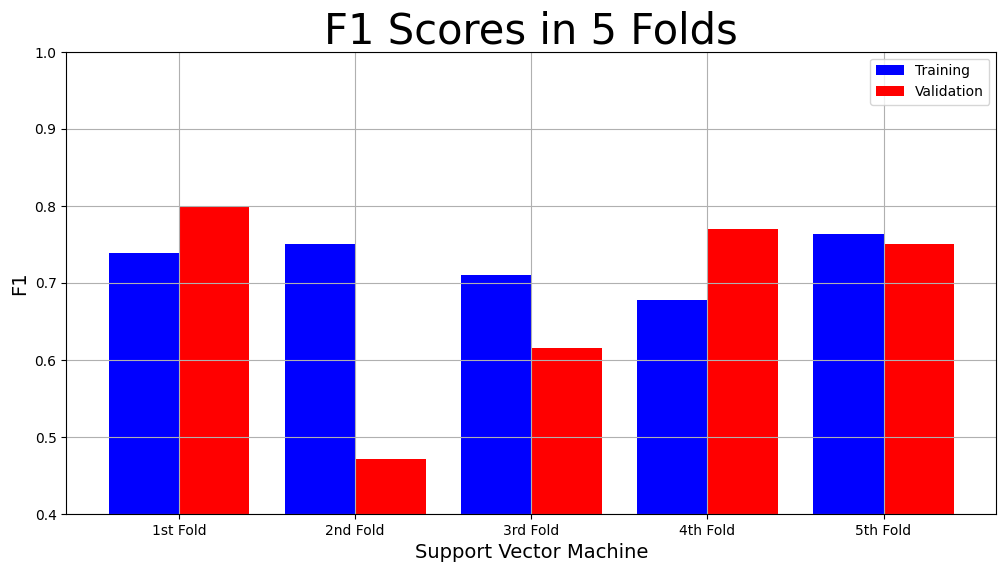

In [245]:
# Plot F1-Score Result
plot_result(model_name,
            "F1",
            "F1 Scores in 5 Folds",
            svm_result["Training F1 scores"],
            svm_result["Validation F1 scores"])

### 5. Decision Tree

In [304]:
%%time

from sklearn.tree import DecisionTreeClassifier

#clf = DecisionTreeClassifier(min_samples_split=10,max_depth=3)
#clf.fit(X_scaled, y_train)

print("train shape: " + str(X_train.shape))
print("score on test: "  + str(fit_models['clf'].score(X_test, y_test)))
print("score on train: " + str(fit_models['clf'].score(X_train, y_train)))

train shape: (76, 6)
score on test: 0.6
score on train: 0.8157894736842105
CPU times: total: 0 ns
Wall time: 12 ms


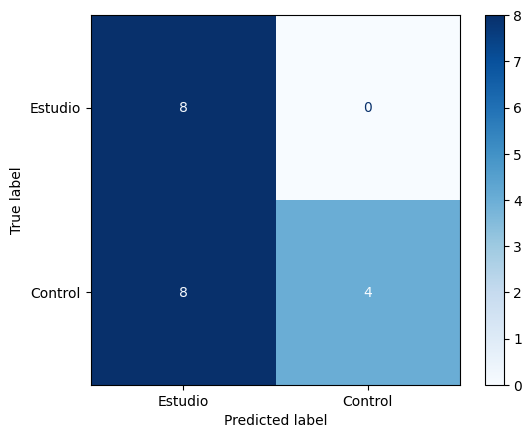

In [305]:
class_names = ['Estudio', 'Control']
ConfusionMatrixDisplay.from_estimator(fit_models['clf'], X_test, y_test, display_labels=class_names, cmap=plt.cm.Blues)
plt.show()

In [306]:
print(classification_report(y_true=y_test,y_pred=fit_models['clf'].predict(X_test)))

              precision    recall  f1-score   support

           0       0.50      1.00      0.67         8
           1       1.00      0.33      0.50        12

    accuracy                           0.60        20
   macro avg       0.75      0.67      0.58        20
weighted avg       0.80      0.60      0.57        20



<Axes: title={'center': 'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

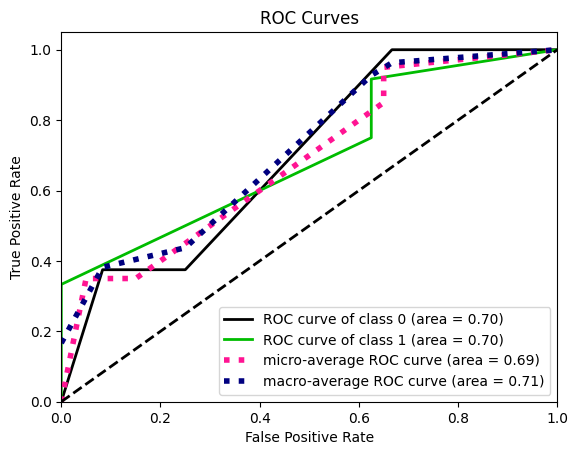

In [307]:
y_predicted = fit_models['clf'].predict_proba(X_test)
plot_roc(y_test, y_predicted)

In [247]:
clf = DecisionTreeClassifier(min_samples_split=10,max_depth=3)
clf_result = cross_validation(clf, X_scaled, y_train, 5)
clf_result

{'Training Accuracy scores': array([0.76666667, 0.91803279, 0.83606557, 0.85245902, 0.83606557]),
 'Mean Training Accuracy': 84.18579234972678,
 'Training Precision scores': array([0.83333333, 0.88235294, 0.81818182, 1.        , 0.95454545]),
 'Mean Training Precision': 0.8976827094474154,
 'Training Recall scores': array([0.66666667, 0.96774194, 0.87096774, 0.7       , 0.7       ]),
 'Mean Training Recall': 0.7810752688172042,
 'Training F1 scores': array([0.74074074, 0.92307692, 0.84375   , 0.82352941, 0.80769231]),
 'Mean Training F1 Score': 0.8277578766549354,
 'Validation Accuracy scores': array([0.6875    , 0.53333333, 0.73333333, 0.53333333, 0.46666667]),
 'Mean Validation Accuracy': 59.08333333333333,
 'Validation Precision scores': array([0.8       , 0.5       , 0.71428571, 0.66666667, 0.5       ]),
 'Mean Validation Precision': 0.6361904761904762,
 'Validation Recall scores': array([0.5       , 0.57142857, 0.71428571, 0.25      , 0.25      ]),
 'Mean Validation Recall': 0.457

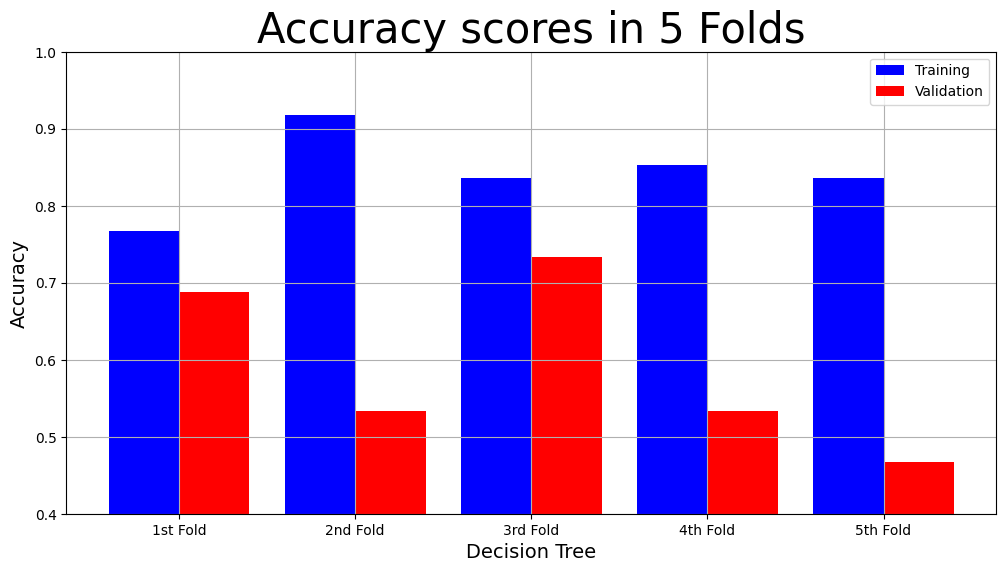

In [248]:
model_name = "Decision Tree"
plot_result(model_name,
            "Accuracy",
            "Accuracy scores in 5 Folds",
            clf_result["Training Accuracy scores"],
            clf_result["Validation Accuracy scores"])

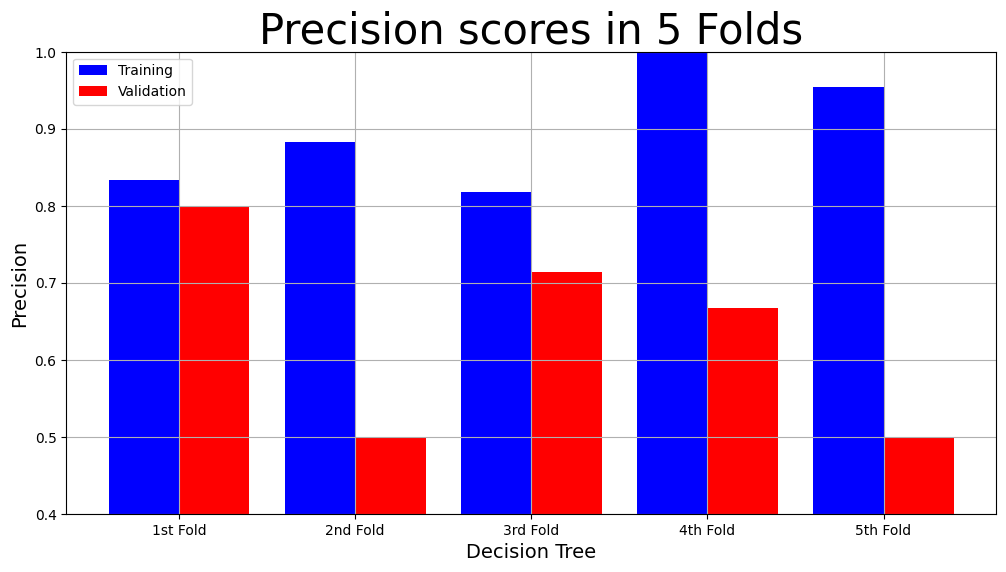

In [249]:
# Plot Precision Result
plot_result(model_name,
            "Precision",
            "Precision scores in 5 Folds",
            clf_result["Training Precision scores"],
            clf_result["Validation Precision scores"])

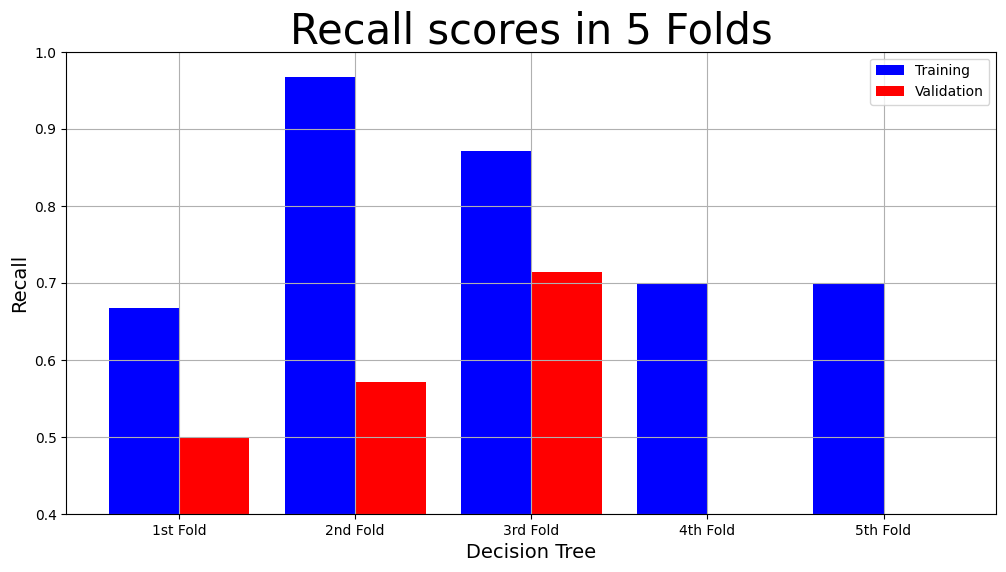

In [250]:
# Plot Recall Result
plot_result(model_name,
            "Recall",
            "Recall scores in 5 Folds",
            clf_result["Training Recall scores"],
            clf_result["Validation Recall scores"])

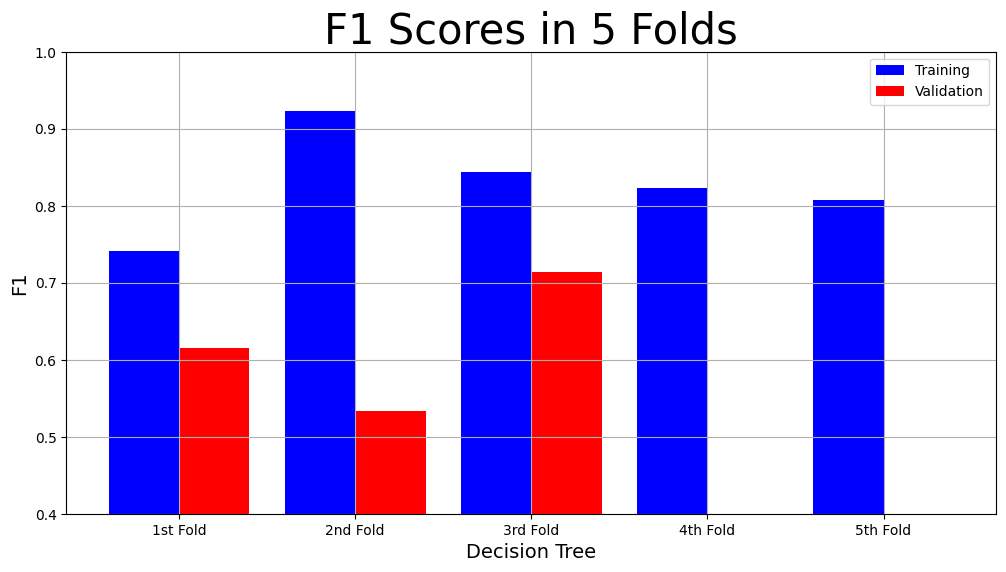

In [251]:
# Plot F1-Score Result
plot_result(model_name,
            "F1",
            "F1 Scores in 5 Folds",
            clf_result["Training F1 scores"],
            clf_result["Validation F1 scores"])

### 6. Bagging Decision Tree

In [309]:
%%time

from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

# x_train_s= X_scaled.tolist()
# x_test_s = X_test_scaled.tolist()

# bg=BaggingClassifier(DecisionTreeClassifier(min_samples_split=10,max_depth=3),max_samples=0.5,max_features=1.0,n_estimators=10)
# bg.fit(x_train_s, y_train)

print("train shape: " + str(X_train.shape))
print("score on test: " + str(fit_models['bg'].score(X_test, y_test)))
print("score on train: "+ str(fit_models['bg'].score(X_train, y_train)))

train shape: (76, 6)
score on test: 0.75
score on train: 0.7763157894736842
CPU times: total: 15.6 ms
Wall time: 18.5 ms


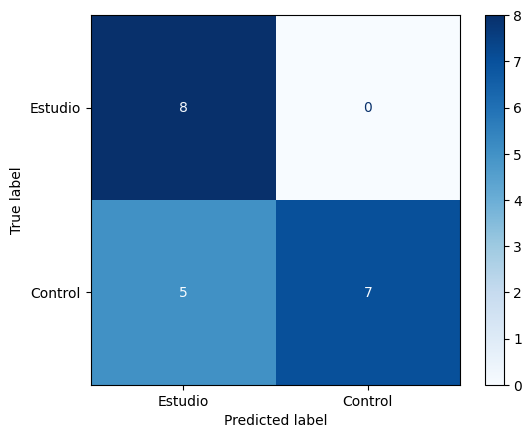

In [310]:
class_names = ['Estudio', 'Control']
ConfusionMatrixDisplay.from_estimator(fit_models['bg'], X_test, y_test, display_labels=class_names, cmap=plt.cm.Blues)
plt.show()

In [311]:
print(classification_report(y_true=y_test,y_pred=fit_models['bg'].predict(X_test)))

              precision    recall  f1-score   support

           0       0.62      1.00      0.76         8
           1       1.00      0.58      0.74        12

    accuracy                           0.75        20
   macro avg       0.81      0.79      0.75        20
weighted avg       0.85      0.75      0.75        20



<Axes: title={'center': 'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

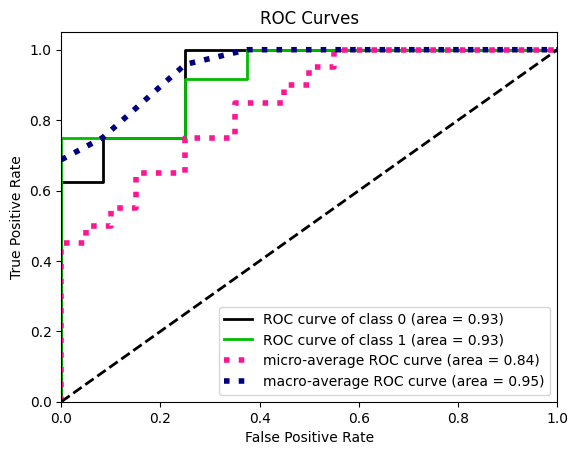

In [312]:
y_predicted = fit_models['bg'].predict_proba(X_test)
plot_roc(y_test, y_predicted)

In [252]:
x_train_s= X_scaled.tolist()
y_= y_train.label.values
bg=BaggingClassifier(DecisionTreeClassifier(min_samples_split=10,max_depth=3),max_samples=0.5,max_features=1.0,n_estimators=10)
bg_result = cross_validation(bg, x_train_s, y_train, 5)
bg_result

{'Training Accuracy scores': array([0.81666667, 0.81967213, 0.83606557, 0.83606557, 0.7704918 ]),
 'Mean Training Accuracy': 81.5792349726776,
 'Training Precision scores': array([0.78787879, 0.85714286, 0.81818182, 0.83333333, 0.71052632]),
 'Mean Training Precision': 0.8014126224652541,
 'Training Recall scores': array([0.86666667, 0.77419355, 0.87096774, 0.83333333, 0.9       ]),
 'Mean Training Recall': 0.8490322580645161,
 'Training F1 scores': array([0.82539683, 0.81355932, 0.84375   , 0.83333333, 0.79411765]),
 'Mean Training F1 Score': 0.8220314255645761,
 'Validation Accuracy scores': array([0.75      , 0.66666667, 0.66666667, 0.6       , 0.73333333]),
 'Mean Validation Accuracy': 68.33333333333333,
 'Validation Precision scores': array([0.7       , 0.75      , 0.625     , 0.66666667, 0.66666667]),
 'Mean Validation Precision': 0.6816666666666666,
 'Validation Recall scores': array([0.875     , 0.42857143, 0.71428571, 0.5       , 1.        ]),
 'Mean Validation Recall': 0.7035

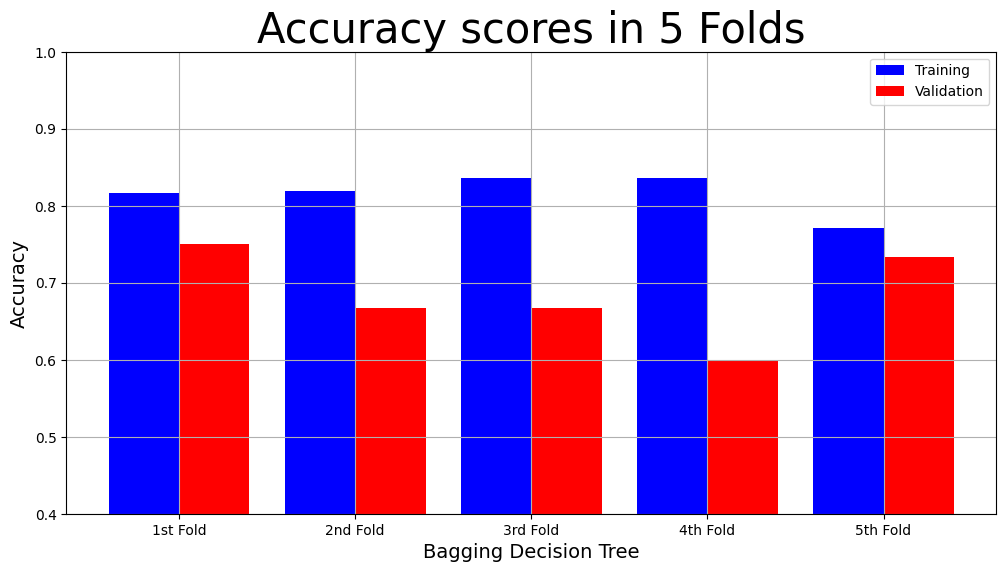

In [253]:
model_name = "Bagging Decision Tree"
plot_result(model_name,
            "Accuracy",
            "Accuracy scores in 5 Folds",
            bg_result["Training Accuracy scores"],
            bg_result["Validation Accuracy scores"])

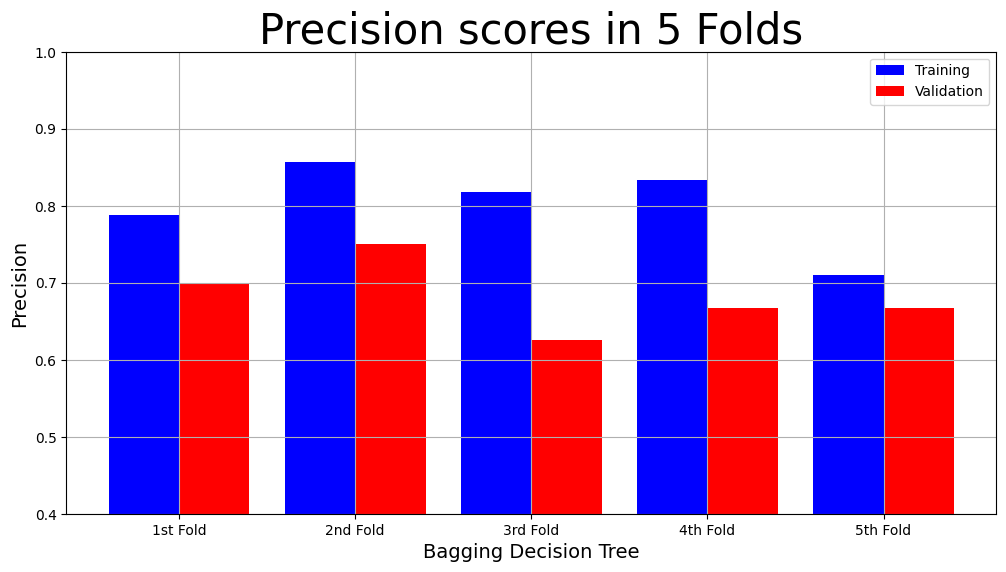

In [254]:
# Plot Precision Result
plot_result(model_name,
            "Precision",
            "Precision scores in 5 Folds",
            bg_result["Training Precision scores"],
            bg_result["Validation Precision scores"])

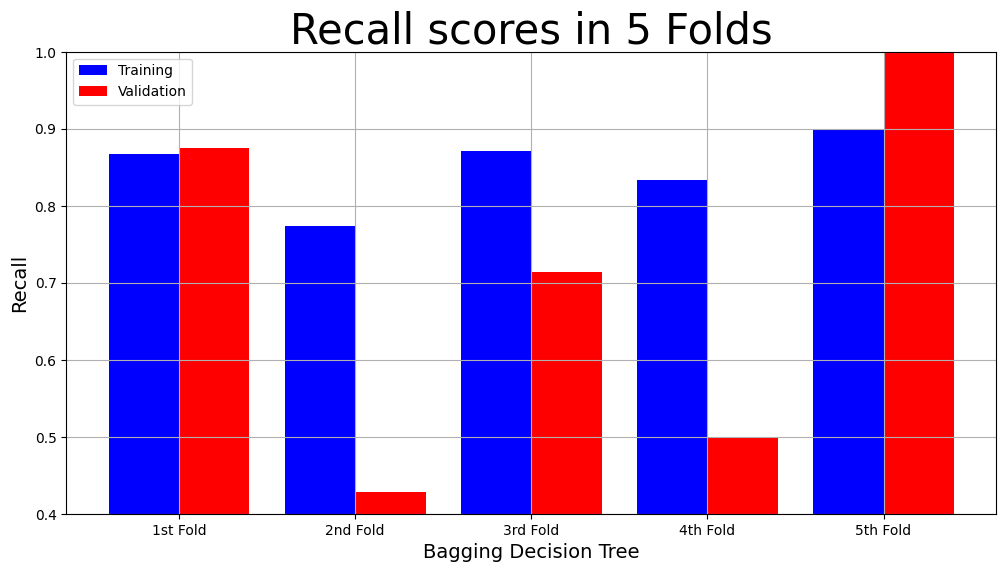

In [255]:
# Plot Recall Result
plot_result(model_name,
            "Recall",
            "Recall scores in 5 Folds",
            bg_result["Training Recall scores"],
            bg_result["Validation Recall scores"])

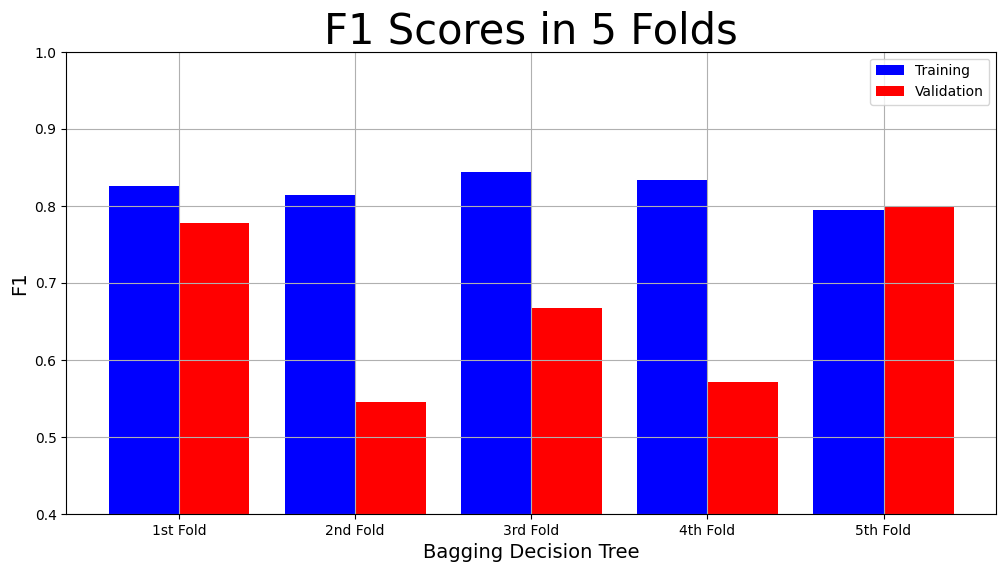

In [256]:
# Plot F1-Score Result
plot_result(model_name,
            "F1",
            "F1 Scores in 5 Folds",
            bg_result["Training F1 scores"],
            bg_result["Validation F1 scores"])

### 7. Boosting Decision Tree

In [313]:
%%time

from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

# setting 
# min_samples_split=10
# max_depth=4

# adb = AdaBoostClassifier(DecisionTreeClassifier(max_depth=2),n_estimators=100,learning_rate=0.5)
# adb.fit(X_scaled, y_train)

print("train shape: " + str(X_train.shape))
print("score on test: " + str(fit_models['adb'].score(X_test, y_test)))
print("score on train: "+ str(fit_models['adb'].score(X_scaled, y_train)))

train shape: (76, 6)
score on test: 0.75
score on train: 0.5
CPU times: total: 46.9 ms
Wall time: 50.1 ms


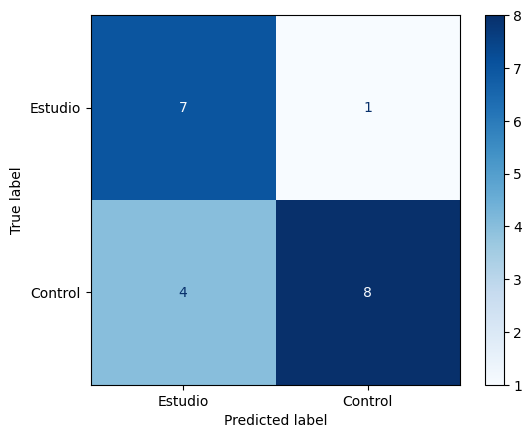

In [314]:
class_names = ['Estudio', 'Control']
ConfusionMatrixDisplay.from_estimator(fit_models['adb'], X_test, y_test, display_labels=class_names, cmap=plt.cm.Blues)
plt.show()

In [315]:
print(classification_report(y_true=y_test,y_pred=fit_models['adb'].predict(X_test)))

              precision    recall  f1-score   support

           0       0.64      0.88      0.74         8
           1       0.89      0.67      0.76        12

    accuracy                           0.75        20
   macro avg       0.76      0.77      0.75        20
weighted avg       0.79      0.75      0.75        20



<Axes: title={'center': 'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

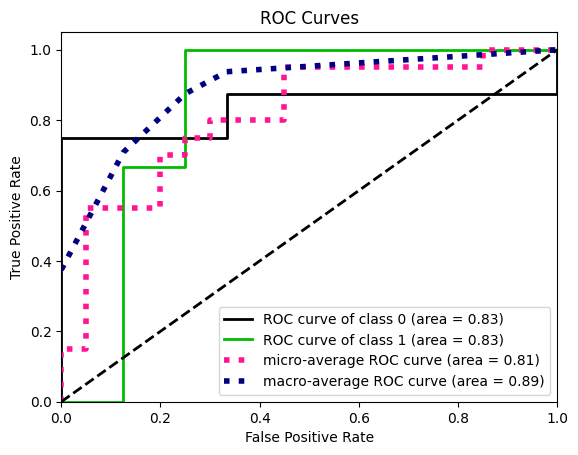

In [316]:
y_predicted = fit_models['adb'].predict_proba(X_test)
plot_roc(y_test, y_predicted)

In [257]:
adb = AdaBoostClassifier(DecisionTreeClassifier(max_depth=2),n_estimators=100,learning_rate=0.5)
adb_result = cross_validation(adb, X_scaled, y_train, 5)
adb_result

{'Training Accuracy scores': array([1., 1., 1., 1., 1.]),
 'Mean Training Accuracy': 100.0,
 'Training Precision scores': array([1., 1., 1., 1., 1.]),
 'Mean Training Precision': 1.0,
 'Training Recall scores': array([1., 1., 1., 1., 1.]),
 'Mean Training Recall': 1.0,
 'Training F1 scores': array([1., 1., 1., 1., 1.]),
 'Mean Training F1 Score': 1.0,
 'Validation Accuracy scores': array([0.4375    , 0.46666667, 0.73333333, 0.73333333, 0.6       ]),
 'Mean Validation Accuracy': 59.416666666666664,
 'Validation Precision scores': array([0.45454545, 0.4       , 0.71428571, 0.75      , 0.75      ]),
 'Mean Validation Precision': 0.6137662337662337,
 'Validation Recall scores': array([0.625     , 0.28571429, 0.71428571, 0.75      , 0.375     ]),
 'Mean Validation Recall': 0.55,
 'Validation F1 scores': array([0.52631579, 0.33333333, 0.71428571, 0.75      , 0.5       ]),
 'Mean Validation F1 Score': 0.5647869674185464}

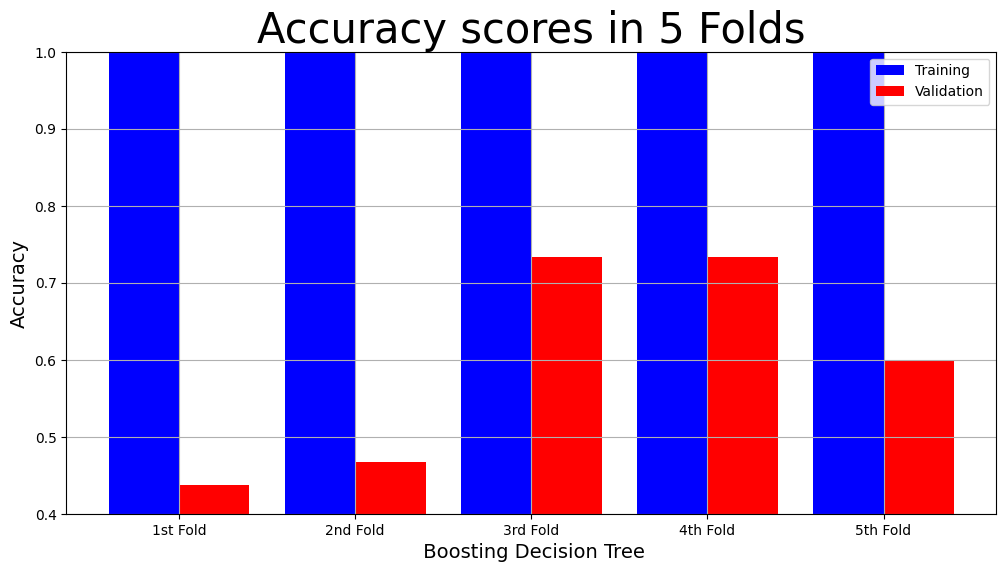

In [258]:
model_name = " Boosting Decision Tree"
plot_result(model_name,
            "Accuracy",
            "Accuracy scores in 5 Folds",
            adb_result["Training Accuracy scores"],
            adb_result["Validation Accuracy scores"])

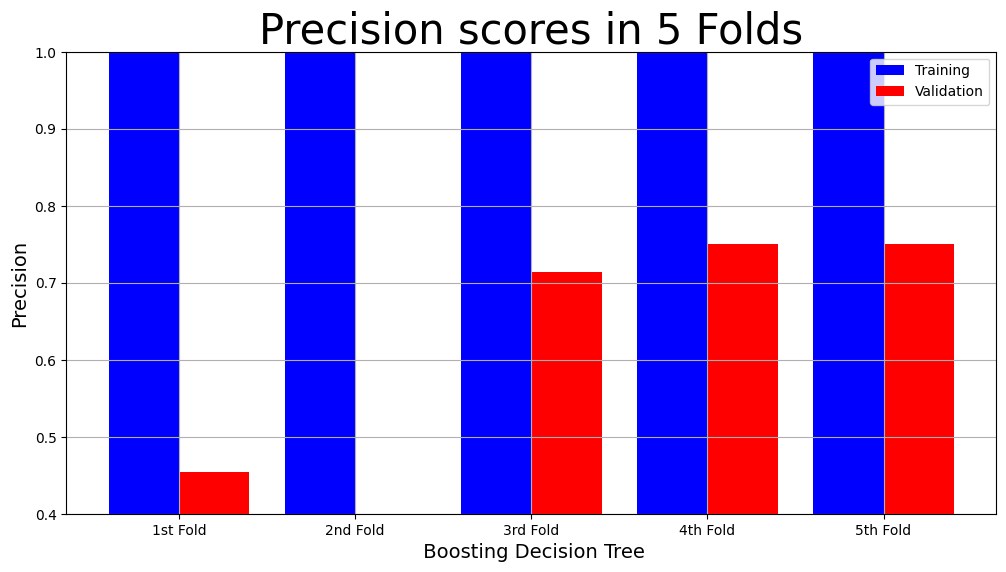

In [259]:
# Plot Precision Result
plot_result(model_name,
            "Precision",
            "Precision scores in 5 Folds",
            adb_result["Training Precision scores"],
            adb_result["Validation Precision scores"])

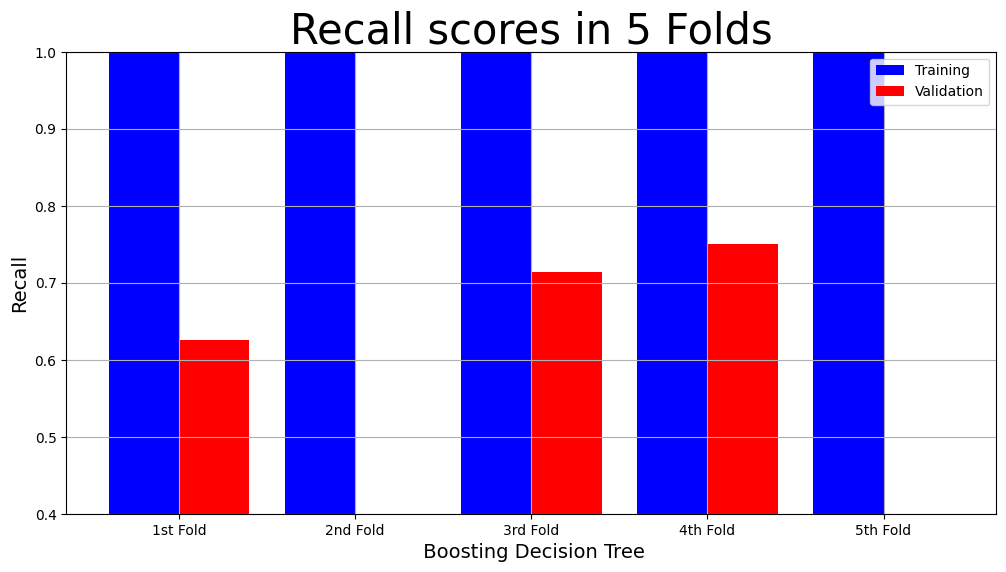

In [260]:
# Plot Recall Result
plot_result(model_name,
            "Recall",
            "Recall scores in 5 Folds",
            adb_result["Training Recall scores"],
            adb_result["Validation Recall scores"])

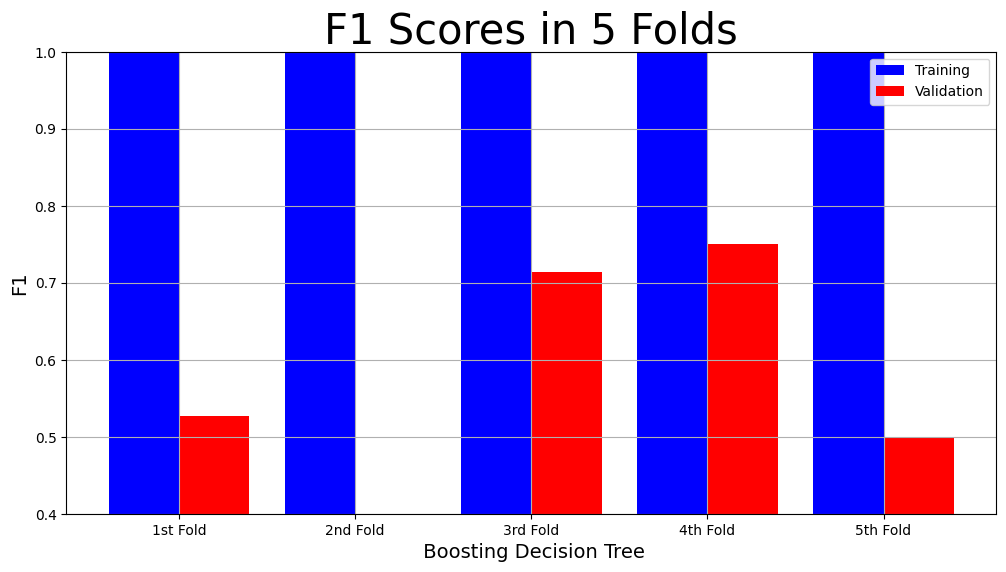

In [261]:
# Plot F1-Score Result
plot_result(model_name,
            "F1",
            "F1 Scores in 5 Folds",
            adb_result["Training F1 scores"],
            adb_result["Validation F1 scores"])

### 8. Random Forest

In [317]:
%%time

from sklearn.ensemble import RandomForestClassifier

# n_estimators = number of desission trees
## rf = RandomForestClassifier(n_estimators=300,max_depth=3)
## rf.fit(X_scaled, y_train)

print("score on test: " + str(fit_models['rf'].score(X_test, y_test)))
print("score on train: "+ str(fit_models['rf'].score(X_train, y_train)))

score on test: 0.85
score on train: 0.8947368421052632
CPU times: total: 46.9 ms
Wall time: 71.2 ms


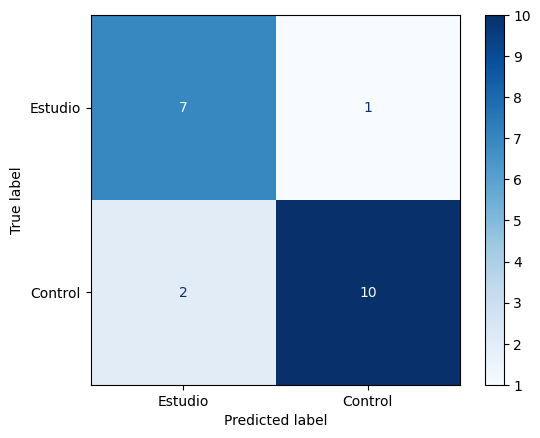

In [318]:
class_names = ['Estudio', 'Control']
ConfusionMatrixDisplay.from_estimator(fit_models['rf'], X_test, y_test, display_labels=class_names, cmap=plt.cm.Blues)
plt.show()

In [319]:
print(classification_report(y_true=y_test,y_pred=fit_models['rf'].predict(X_test)))

              precision    recall  f1-score   support

           0       0.78      0.88      0.82         8
           1       0.91      0.83      0.87        12

    accuracy                           0.85        20
   macro avg       0.84      0.85      0.85        20
weighted avg       0.86      0.85      0.85        20



<Axes: title={'center': 'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

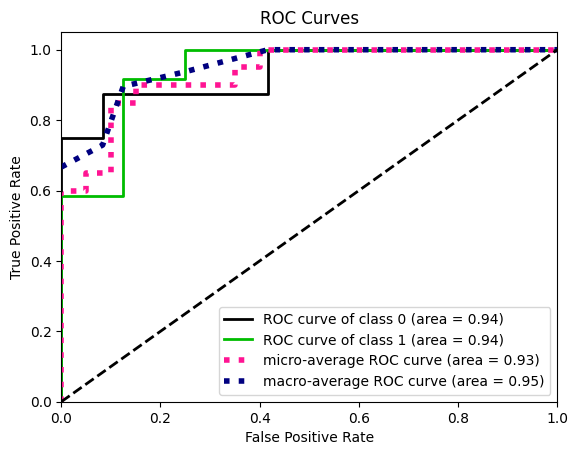

In [320]:
y_predicted = fit_models['rf'].predict_proba(X_test)
plot_roc(y_test, y_predicted)

In [262]:
rf = RandomForestClassifier(n_estimators=300,max_depth=3)
rf_result = cross_validation(rf, X_scaled, y_train, 5)
rf_result

{'Training Accuracy scores': array([0.91666667, 0.91803279, 0.91803279, 0.91803279, 0.91803279]),
 'Mean Training Accuracy': 91.77595628415301,
 'Training Precision scores': array([0.90322581, 0.90625   , 0.90625   , 0.90322581, 0.93103448]),
 'Mean Training Precision': 0.9099972191323694,
 'Training Recall scores': array([0.93333333, 0.93548387, 0.93548387, 0.93333333, 0.9       ]),
 'Mean Training Recall': 0.9275268817204301,
 'Training F1 scores': array([0.91803279, 0.92063492, 0.92063492, 0.91803279, 0.91525424]),
 'Mean Training F1 Score': 0.9185179304656937,
 'Validation Accuracy scores': array([0.8125    , 0.53333333, 0.66666667, 0.66666667, 0.66666667]),
 'Mean Validation Accuracy': 66.91666666666666,
 'Validation Precision scores': array([0.77777778, 0.5       , 0.625     , 0.8       , 0.71428571]),
 'Mean Validation Precision': 0.6834126984126984,
 'Validation Recall scores': array([0.875     , 0.42857143, 0.71428571, 0.5       , 0.625     ]),
 'Mean Validation Recall': 0.628

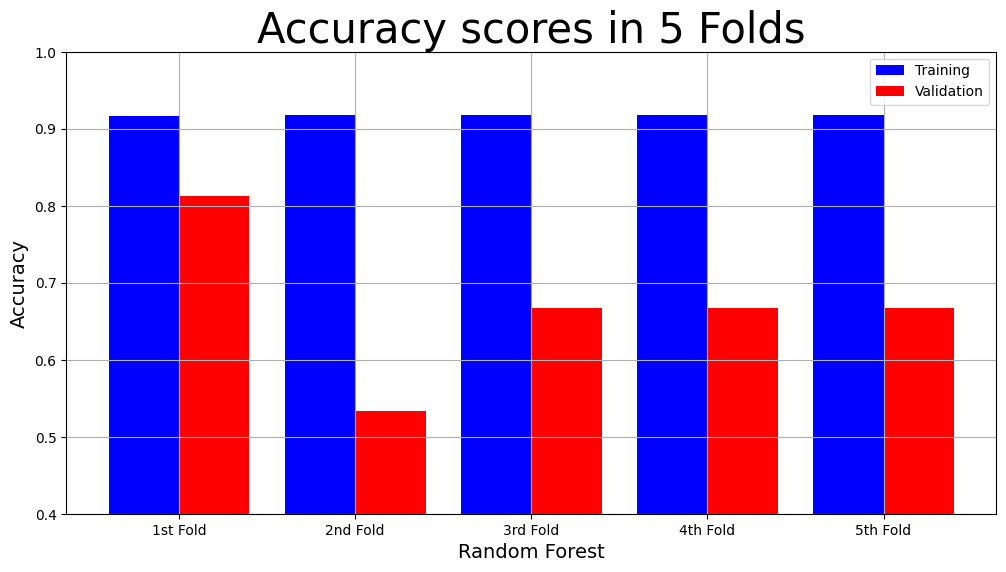

In [263]:
model_name = "Random Forest"
plot_result(model_name,
            "Accuracy",
            "Accuracy scores in 5 Folds",
            rf_result["Training Accuracy scores"],
            rf_result["Validation Accuracy scores"])

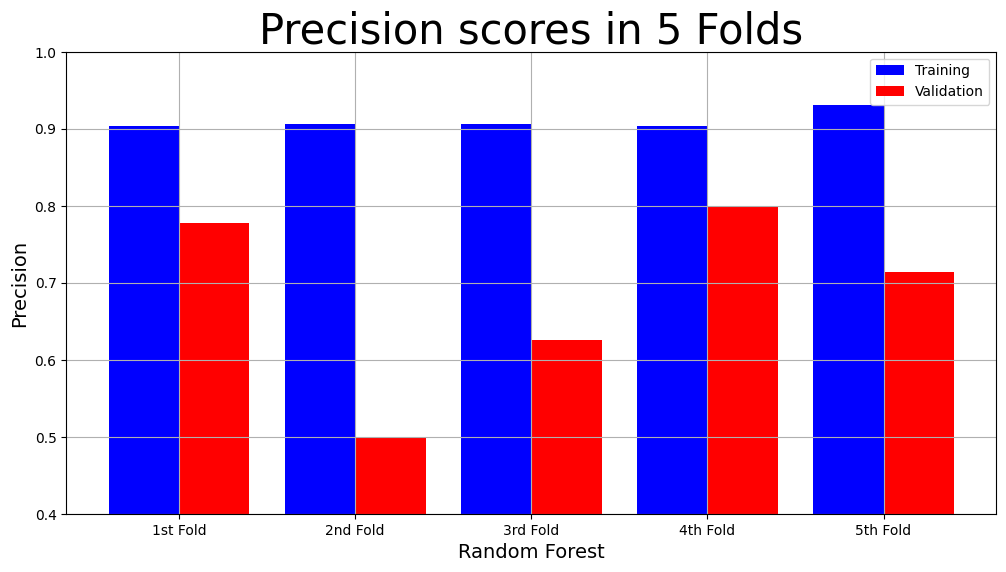

In [264]:
# Plot Precision Result
plot_result(model_name,
            "Precision",
            "Precision scores in 5 Folds",
            rf_result["Training Precision scores"],
            rf_result["Validation Precision scores"])

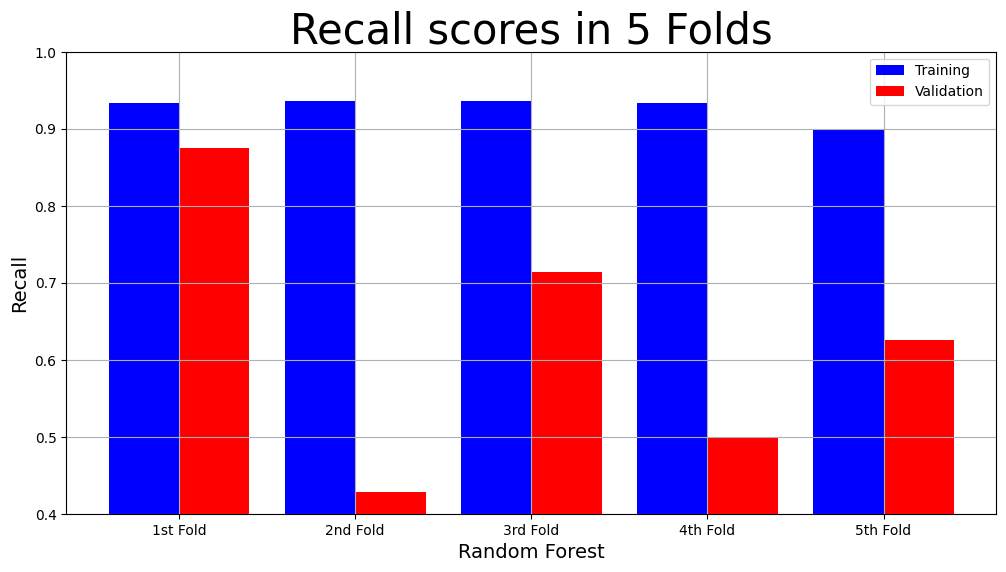

In [265]:
# Plot Recall Result
plot_result(model_name,
            "Recall",
            "Recall scores in 5 Folds",
            rf_result["Training Recall scores"],
            rf_result["Validation Recall scores"])

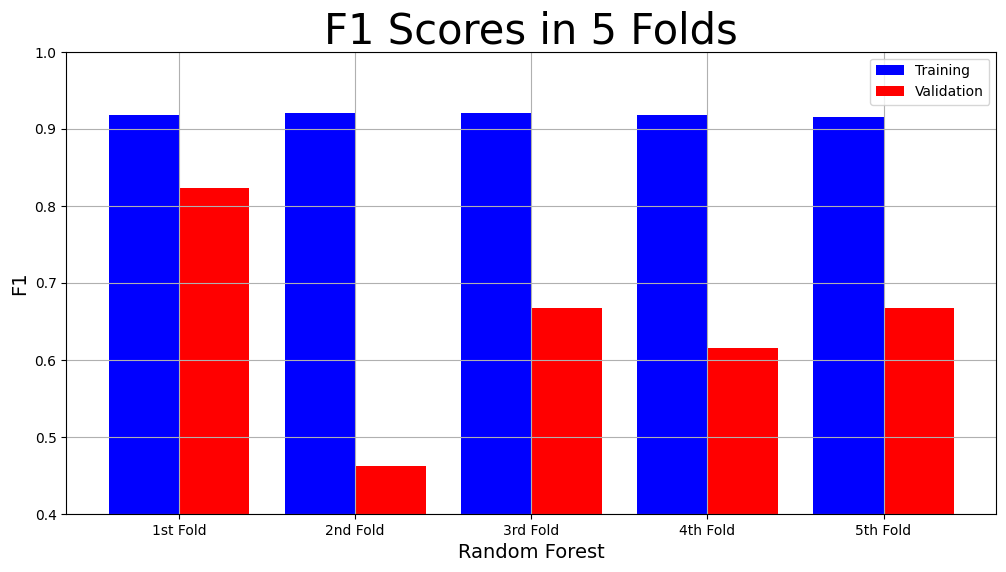

In [266]:
# Plot F1-Score Result
plot_result(model_name,
            "F1",
            "F1 Scores in 5 Folds",
            rf_result["Training F1 scores"],
            rf_result["Validation F1 scores"])

### 9. Voting Classifier

In [321]:
%%time

from sklearn.ensemble import VotingClassifier

# 1) naive bias = mnb
#mnb = MultinomialNB().fit(X_norm, y_train)
# 2) logistic regression =lr
#lr=LogisticRegression(max_iter=5000)
# 3) random forest =rf
#rf = RandomForestClassifier(n_estimators=30,max_depth=3)
# 4) suport vecotr mnachine = svm
#svm=LinearSVC(max_iter=5000)


#evc=VotingClassifier(estimators=[('mnb',mnb),('lr',lr),('rf',rf),('svm',svm)])
#evc.fit(X_norm, y_train)

print("score on test: " + str(fit_models['evc'].score(X_test, y_test)))
print("score on train: "+ str(fit_models['evc'].score(X_train, y_train)))

score on test: 0.95
score on train: 0.7631578947368421
CPU times: total: 0 ns
Wall time: 21 ms


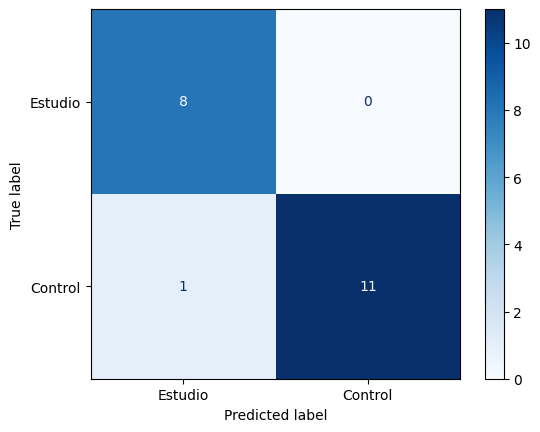

In [322]:
class_names = ['Estudio', 'Control']
ConfusionMatrixDisplay.from_estimator(fit_models['evc'], X_test, y_test, display_labels=class_names, cmap=plt.cm.Blues)
plt.show()

In [323]:
print(classification_report(y_true=y_test,y_pred=fit_models['evc'].predict(X_test)))

              precision    recall  f1-score   support

           0       0.89      1.00      0.94         8
           1       1.00      0.92      0.96        12

    accuracy                           0.95        20
   macro avg       0.94      0.96      0.95        20
weighted avg       0.96      0.95      0.95        20



In [267]:
# 1) naive bias = mnb
mnb = MultinomialNB().fit(X_norm, y_train)
# 2) logistic regression =lr
lr=LogisticRegression(max_iter=5000)
# 3) random forest =rf
rf = RandomForestClassifier(n_estimators=30,max_depth=3)
# 4) suport vecotr mnachine = svm
svm=LinearSVC(max_iter=5000)
evc=VotingClassifier(estimators=[('mnb',mnb),('lr',lr),('rf',rf),('svm',svm)])

evc_result = cross_validation(evc, X_norm, y_train, 5)
evc_result

{'Training Accuracy scores': array([0.75      , 0.81967213, 0.7704918 , 0.75409836, 0.7704918 ]),
 'Mean Training Accuracy': 77.29508196721311,
 'Training Precision scores': array([0.74193548, 0.8125    , 0.75757576, 0.8       , 0.86363636]),
 'Mean Training Precision': 0.7951295210166178,
 'Training Recall scores': array([0.76666667, 0.83870968, 0.80645161, 0.66666667, 0.63333333]),
 'Mean Training Recall': 0.7423655913978495,
 'Training F1 scores': array([0.75409836, 0.82539683, 0.78125   , 0.72727273, 0.73076923]),
 'Mean Training F1 Score': 0.7637574288189042,
 'Validation Accuracy scores': array([0.8125    , 0.46666667, 0.73333333, 0.73333333, 0.73333333]),
 'Mean Validation Accuracy': 69.58333333333334,
 'Validation Precision scores': array([0.85714286, 0.44444444, 0.71428571, 1.        , 0.75      ]),
 'Mean Validation Precision': 0.7531746031746032,
 'Validation Recall scores': array([0.75      , 0.57142857, 0.71428571, 0.5       , 0.75      ]),
 'Mean Validation Recall': 0.657

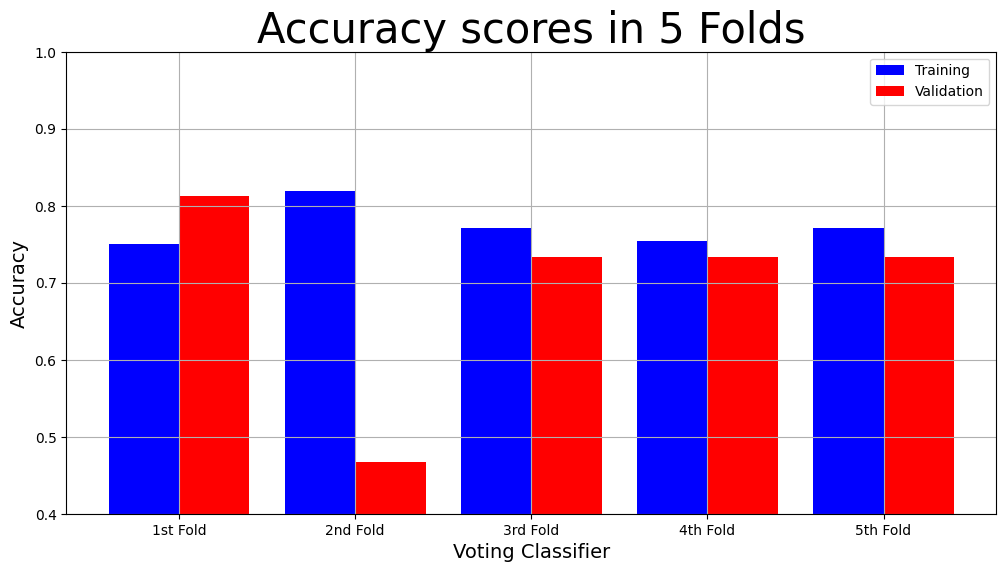

In [268]:
model_name = "Voting Classifier"
plot_result(model_name,
            "Accuracy",
            "Accuracy scores in 5 Folds",
            evc_result["Training Accuracy scores"],
            evc_result["Validation Accuracy scores"])

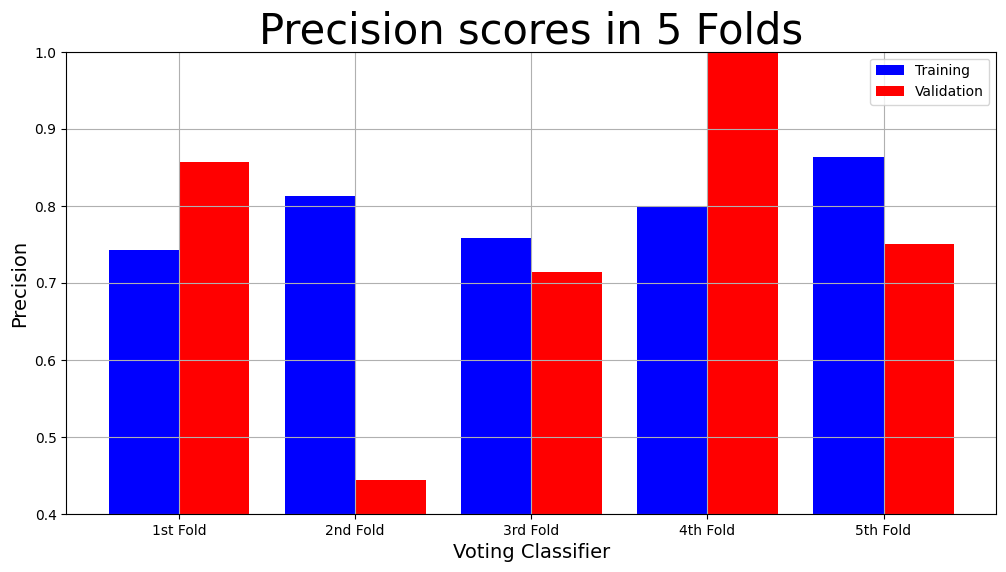

In [269]:
# Plot Precision Result
plot_result(model_name,
            "Precision",
            "Precision scores in 5 Folds",
            evc_result["Training Precision scores"],
            evc_result["Validation Precision scores"])

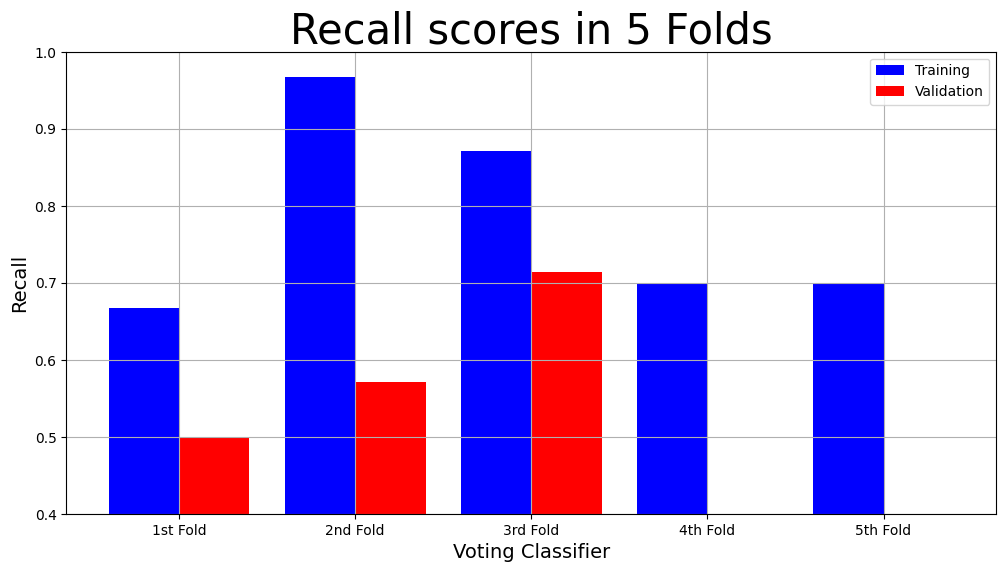

In [270]:
# Plot Recall Result
plot_result(model_name,
            "Recall",
            "Recall scores in 5 Folds",
            lr_result["Training Recall scores"],
            lr_result["Validation Recall scores"])

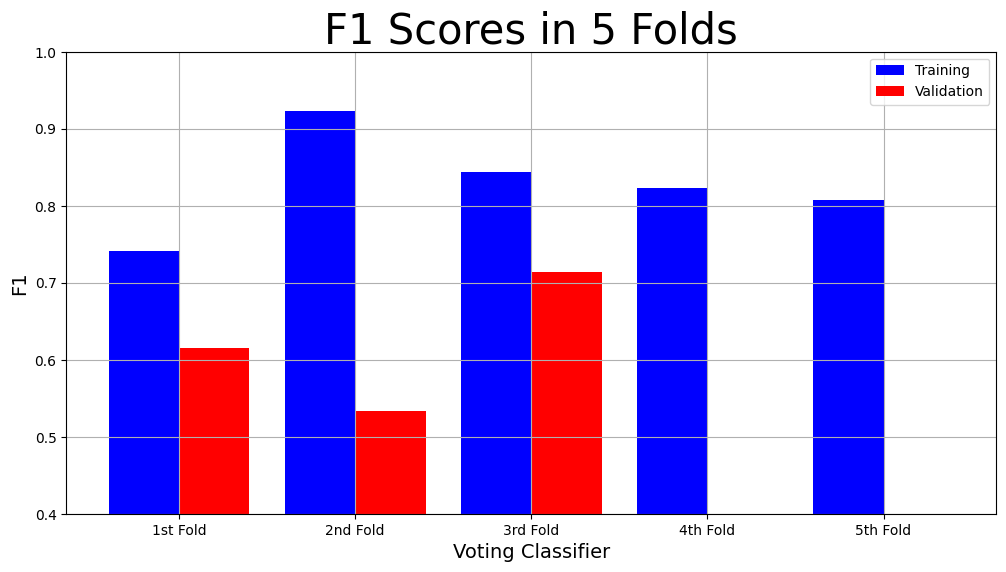

In [271]:
# Plot F1-Score Result
plot_result(model_name,
            "F1",
            "F1 Scores in 5 Folds",
            lr_result["Training F1 scores"],
            lr_result["Validation F1 scores"])

### accuray score

In [72]:
%%time
from sklearn.model_selection import cross_val_score

for clf, label in zip([mnb, lr, rf, svm, evc], ['Naive Bayes', 'Logistic Regression', 'Random Forest', 'Support Vector Machine','Ensemble']):
    if label == 'Naive Bayes' or label == 'Ensemble':
        scores = cross_val_score(clf, X_norm, y_train, scoring='accuracy', cv=5)
    else:   
        scores = cross_val_score(clf, X_scaled, y_train, scoring='accuracy', cv=5)
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))

Accuracy: 0.62 (+/- 0.08) [Naive Bayes]
Accuracy: 0.68 (+/- 0.18) [Logistic Regression]
Accuracy: 0.66 (+/- 0.07) [Random Forest]
Accuracy: 0.68 (+/- 0.18) [Support Vector Machine]
Accuracy: 0.67 (+/- 0.12) [Ensemble]
CPU times: total: 219 ms
Wall time: 632 ms
